# Final Project Notebook

**University of California, Berkeley**

**MIDS Program** - W207 Applied Machine Learning

**Section 7** - Mackenzie Austin, Emanuel Mejía, Ibrahim Shareef

In [1]:
# ! pip install imblearn
# ! pip install graphviz

In [2]:
import os
import numpy as np
import pandas as pd
import random
import math
import warnings
warnings.filterwarnings('ignore')

#from PIL import Image
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
from matplotlib import pyplot as plt
import tensorflow as tf
#import sklearn
from tensorflow import keras
from keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#tf.get_logger().setLevel('INFO')
import imblearn
from imblearn.over_sampling import SMOTE
from timeit import default_timer as timer

# import sklearn
from sklearn import tree
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

start = timer()

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Download and Load Data </div>

In [3]:
#setup dataset

# !mkdir input
# !cd input && kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset && tar -xf alzheimer-mri-dataset.zip

In [4]:
X = np.empty((6400, 128, 128, 3))
Y = np.empty(6400, dtype=int)
label_names = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
index = 0
for subdir, dirs, files in os.walk('./input/Dataset/Non_Demented'):
    
    for file in files:
        img = load_img(os.path.join(subdir, file), target_size=(128,128))
        #print(type(img))
        #print(img.format)
        #print(img.mode)
        #print(img.size)
        
#         for grayscale
#         img_arr = img_to_array(img.convert('L'))
#         print(img_arr.shape)
#         print(img_arr)
#         img_arr = img_arr.reshape((128,-1))
#         print(img_arr.shape)
#         print(img_arr)
        
        img_arr = img_to_array(img)
        X[index] = img_arr
        Y[index] = 0
        index += 1
        
for subdir, dirs, files in os.walk('./input/Dataset/Very_Mild_Demented'):
    for file in files:
        img = load_img(os.path.join(subdir, file), target_size=(128,128))
        img_arr = img_to_array(img)
        X[index] = img_arr
        Y[index] = 1
        index += 1
        
for subdir, dirs, files in os.walk('./input/Dataset/Mild_Demented'):
    for file in files:
        img = load_img(os.path.join(subdir, file), target_size=(128,128))
        img_arr = img_to_array(img)
        X[index] = img_arr
        Y[index] = 2
        index += 1
        
for subdir, dirs, files in os.walk('./input/Dataset/Moderate_Demented'):
    for file in files:
        img = load_img(os.path.join(subdir, file), target_size=(128,128))
        img_arr = img_to_array(img)
        X[index] = img_arr
        Y[index] = 3
        index += 1
        
print(X.shape)
print(Y.shape)

(6400, 128, 128, 3)
(6400,)


count     %
Non Demented         3200  50.0
Very Mild Demented   2240  35.0
Mild Demented         896  14.0
Moderate Demented      64   1.0

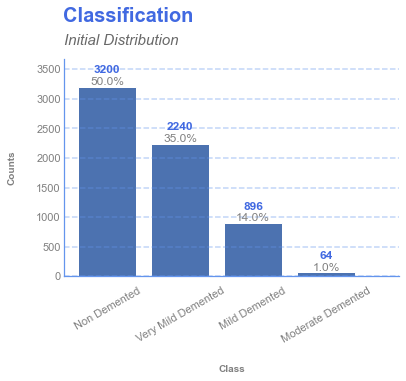

In [5]:
diagnoses = pd.Series(Y)
diagnoses = diagnoses.replace([0, 1, 2, 3], label_names)
diag_df = pd.DataFrame({'count': diagnoses.value_counts()})
diag_df['%'] = round(diag_df['count'] / len(Y)*100,0)

ax = plt.axes()
plt.bar(diag_df.index, diag_df['count'], align = 'center')
ax.set_xticks([0,1,2,3,4])

# Spine formatting
ax.set_facecolor(color='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('cornflowerblue')
ax.spines['bottom'].set_color('cornflowerblue')

# Tick formatting
ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
ax.tick_params(axis='x', which='both', color='cornflowerblue', 
               colors = 'gray', rotation = 30)

# Grid formatting
ax.grid(False)
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='cornflowerblue', zorder=1)

# Setting text labels according to the count of df
rects = ax.patches
percentages = diag_df['%']
counts = diag_df['count']

for rect, label, cnt in zip(rects, percentages, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, str(label) + '%',
            ha='center', va='bottom', color = 'gray',weight='normal')
    height = rect.get_height() + 200
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, cnt,
            ha='center', va='bottom', color = 'royalblue',weight='bold')
    
# Set title
plt.suptitle("Classification", x = 0.123, y = 1.06, ha = 'left', weight='bold', color = 'royalblue', 
             size=20)

# Set title
ax.set_title("Initial Distribution", weight='normal', color = 'dimgray', 
             style = 'italic', pad=14, loc='left', size=15)

# Set x-axis label
ax.set_xlabel("Class", labelpad=20, weight='bold', size=10, color='gray')

# Set y-axis label
ax.set_ylabel("Counts", labelpad=20, weight='bold', size=10, color='gray')

diag_df

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Class Imbalance Sections </div>

In [6]:
# seed randoms in one place

random.seed(5678)
np.random.seed(5678)
tf.random.set_seed(5678)

In [7]:
##Fix Data Imbalance using SMOTE

orig_shape = X.shape
X = np.reshape(X, (orig_shape[0], orig_shape[1] * orig_shape[2] * orig_shape[3]))
oversample = SMOTE()
print('X before smote: ', X.shape)
print('Y before smote: ', Y.shape)
X, Y = oversample.fit_resample(X, Y)
X = np.reshape(X, (X.shape[0], orig_shape[1], orig_shape[2], orig_shape[3]))
print('X after smote: ', X.shape)
print('Y after smote: ', Y.shape)

X before smote:  (6400, 49152)
Y before smote:  (6400,)
X after smote:  (12800, 128, 128, 3)
Y after smote:  (12800,)


count     %
Non Demented         3200  25.0
Very Mild Demented   3200  25.0
Mild Demented        3200  25.0
Moderate Demented    3200  25.0

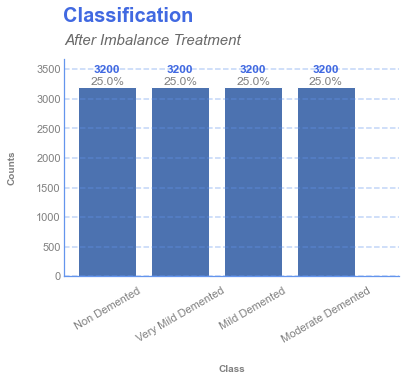

In [8]:
diagnoses = pd.Series(Y)
diagnoses = diagnoses.replace([0, 1, 2, 3], label_names)
diag_df = pd.DataFrame({'count': diagnoses.value_counts()})
diag_df['%'] = round(diag_df['count'] / len(Y)*100,0)
diag_df.index.str.strip()
diag_df = diag_df.reindex(label_names)

ax = plt.axes()
plt.bar(diag_df.index, diag_df['count'], align = 'center')
ax.set_xticks([0,1,2,3,4])

# Spine formatting
ax.set_facecolor(color='white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('cornflowerblue')
ax.spines['bottom'].set_color('cornflowerblue')

# Tick formatting
ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
ax.tick_params(axis='x', which='both', color='cornflowerblue', 
               colors = 'gray', rotation = 30)

# Grid formatting
ax.grid(False)
vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='cornflowerblue', zorder=1)

# Setting text labels according to the count of df
rects = ax.patches
percentages = diag_df['%']
counts = diag_df['count']

for rect, label, cnt in zip(rects, percentages, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, str(label) + '%',
            ha='center', va='bottom', color = 'gray',weight='normal')
    height = rect.get_height() + 200
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, cnt,
            ha='center', va='bottom', color = 'royalblue',weight='bold')
    
# Set title
plt.suptitle("Classification", x = 0.123, y = 1.06, ha = 'left', weight='bold', color = 'royalblue', 
             size=20)

# Set title
ax.set_title("After Imbalance Treatment", weight='normal', color = 'dimgray', 
             style = 'italic', pad=14, loc='left', size=15)

# Set x-axis label
ax.set_xlabel("Class", labelpad=20, weight='bold', size=10, color='gray')

# Set y-axis label
ax.set_ylabel("Counts", labelpad=20, weight='bold', size=10, color='gray')

diag_df

In [9]:
#shuffle input
#np.random.seed(0)
indices = np.arange(X.shape[0])
shuffled_indices = np.random.permutation(indices)
X = X[shuffled_indices]
Y = Y[shuffled_indices]

# Use a ~80/20 train/test split.
idx = (int)(X.shape[0] * 0.8)
X_train = X[:idx]
Y_train = Y[:idx]
X_test = X[idx:]
Y_test = Y[idx:]

X_train = X_train / 255
X_test = X_test / 255

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(10240, 128, 128, 3)
(10240,)
(2560, 128, 128, 3)
(2560,)


<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">PCA</div>

In [10]:
X_train_pca = X_train.reshape(X_train.shape[0], (X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))
X_test_pca = X_test.reshape(X_test.shape[0], (X_test.shape[1] * X_test.shape[2] * X_test.shape[3]))

# Creating a principal component analysis model
# Enough components to keep around 85% of the variance in the original data 
pca = PCA(n_components = 225)

# Feeding the independent variables to the PCA model
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

print(X_train_pca.shape)
print(X_test_pca.shape)

(10240, 225)
(2560, 225)


In [11]:
pca.n_components

225

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">End Class Imbalance Section</div>

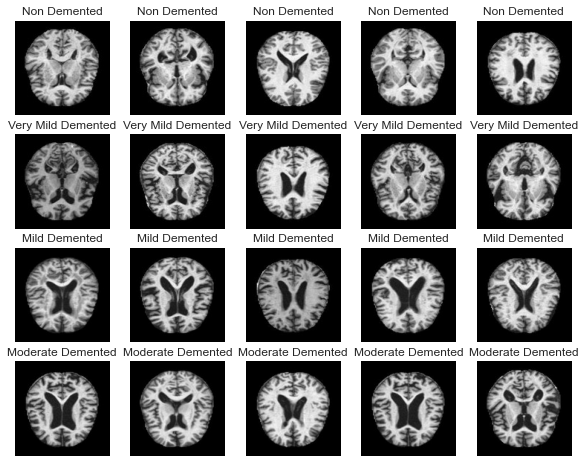

In [12]:
# Showing 5 examples of each class

classes = 4

examples = 5

pic_counter = [0] * classes
i = 0

# Create a figure with subplots.
# As a grid of # product_classes x # examples_per_each

fig, axs = plt.subplots(nrows = classes, ncols= examples, figsize=(10,classes * 2))

# Keep searching until we find all we need

while sum(pic_counter) < (classes * examples):
    
    image = X[i]
    label = int(Y[i])
    label_name = label_names[label]
    
    # Add a picture to the grid 
    # if we haven't find all the examples we need
    # for that product class
    if pic_counter[label] < examples:
        axs[label][pic_counter[label]].imshow(image.astype("uint8"))
        axs[label][pic_counter[label]].set_title(label_name)
        axs[label][pic_counter[label]].axis('off')
        pic_counter[label] += 1
    
    i += 1

plt.show()

In [13]:
def compute_model_performance_metrics(model, x_test, y_test):
    #Record other performance metrics
    x_test_predict = model.predict(x_test, verbose=0)
    x_predict_classes =np.argmax(x_test_predict, axis=1)
    
    accuracy = accuracy_score(y_test, x_predict_classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, x_predict_classes, average='macro')
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, x_predict_classes, average='macro')
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, x_predict_classes, average='macro')
    #auc = roc_auc_score(Y_test, yhat_probs, multi_class='ovr')
    
    metrics = {
        "accuracy": format(accuracy, '.4f'),
        "precision": format(precision, '.4f'),
        "recall": format(recall, '.4f'),
        "f1_score": format(f1, '.4f')
    }
    
    return metrics

In [14]:
def compute_model_performance_metrics_cnn_lstm(model, x_test, y_test):
    #Record other performance metrics
    x_test_predict = model.predict(x_test, verbose=0)

    x_test_predict_shape = x_test_predict.shape
    x_test_predict = np.reshape(x_test_predict, (x_test_predict_shape[0] * x_test_predict_shape[1], x_test_predict_shape[2]))

    y_test_seq_flat = np.reshape(y_test, (y_test.shape[0] * y_test.shape[1]))

    x_predict_classes = np.argmax(x_test_predict, axis=1)
    
    accuracy = accuracy_score(y_test_seq_flat, x_predict_classes)
    # precision tp / (tp + fp)
    precision = precision_score(y_test_seq_flat, x_predict_classes, average='macro')
    # recall: tp / (tp + fn)
    recall = recall_score(y_test_seq_flat, x_predict_classes, average='macro')
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test_seq_flat, x_predict_classes, average='macro')
    
    metrics = {
        "accuracy": format(accuracy, '.4f'),
        "precision": format(precision, '.4f'),
        "recall": format(recall, '.4f'),
        "f1_score": format(f1, '.4f')
    }
    
    return metrics

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Multi-Class Logistic Regression </div>

In [15]:
def build_logreg_model(n_classes = 4, 
                       learning_rate = 0.01, 
                       activation = 'softmax'):
    """Build a multi-class logistic regression model using Keras.

    Args:
        n_classes: Number of classes in the dataset
        learning_rate: The desired learning rate for SGD.

    Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    
    print('Activation function: ' + activation)
    print('Optimizer: SGD')
    print('Learning Rate: ' + str(learning_rate))
    
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
      units = n_classes,
      activation = activation
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)

    model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = optimizer, 
                  metrics = ['accuracy'])
    return model

In [16]:
def train_and_evaluate_logreg(x_train,
                              y_train,
                              x_test,
                              y_test,
                              activation = 'softmax',
                              optimizer = 'SGD',
                              learning_rate = 0.001,
                              num_epochs = 20, 
                              verb = False):
    
    print('Number of Epochs: ' + str(num_epochs))
    
    model = build_logreg_model(n_classes = len(label_names), 
                               learning_rate = learning_rate,
                               activation = activation)

    history = model.fit(
        x = x_train,
        y = y_train,
        epochs = num_epochs,
        batch_size=64,
        verbose = verb,
        validation_split=0.1)

    hist = history.history
    train_accuracy = hist['accuracy']
    val_accuracy = hist['val_accuracy']
    num_params = model.count_params()
    test_predictions = np.argmax(model.predict(x_test, verbose = verb), axis=-1)
    test_accuracy = model.evaluate(x = x_test, y = y_test, verbose = verb,
                               return_dict=True)['accuracy']
  
    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)
    
    ## Plot mean CV accuracies for Tree Depth
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_accuracy, label = "Training Accuracy", 
         color = 'royalblue', marker = '.', lw = 1)
    ax.plot(val_accuracy, label = "Validation Accuracy", 
             color = 'mediumblue', marker = 'D', lw = 2)
    
    # Spine formatting
    ax.set_facecolor(color='white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('cornflowerblue')
    ax.spines['bottom'].set_color('cornflowerblue')
    
    # Tick formatting
    ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
    ax.tick_params(axis='x', which='both', colors = 'gray')
    ax.set_xticks(range(num_epochs + 1))
    
    # Grid formatting
    ax.grid(False)
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)
    
    # Set title
    plt.suptitle("Accuracy vs. Number of Epochs", x = 0.123, y = 1, 
                 ha = 'left', weight='bold', color = 'mediumblue', 
                 size = 18)

    # Set title
    ax.set_title("Training and Validation", weight='normal', color = 'dimgray', 
                 style = 'italic', pad=10, loc='left', size=15)
    
    ax.legend(loc = 4, fontsize = 'medium', 
              shadow = True,
              edgecolor = 'blue',
              labelcolor = ['royalblue','mediumblue'], 
              facecolor = 'ivory')
    
    ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
    ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
    ax.set_ylim(top = 1.01)

    # Use a heatmap plot to display Confusion Matrix.
    ax = fig.add_subplot(1, 2, 2)
    ax = sns.heatmap(confusion_matrix, annot = True, fmt = '.3g', cmap = 'Blues',
                     xticklabels = label_names, yticklabels = label_names, cbar = False)
    
    # Add axis labels.
    ax.tick_params(axis='x', which='both', length=0, colors = 'gray', rotation = 90)
    ax.set_xlabel('Predicted Label', color = 'gray', weight = 'bold')
    ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
    ax.set_ylabel('True Label', color = 'gray', weight = 'bold')

    ax.set_title('CONFUSION MATRIX', 
                 weight='bold', color = 'mediumblue', pad=14, loc='left', size=18)

    ax.text(x = 4, y = -0.22, ha = 'right',
            s = 'TEST ACC: ' + str(round(test_accuracy*100,2)) + '%',
            color = 'mediumblue', weight='bold')
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    
    return [test_accuracy, num_params]

In [17]:
exp_ind = ['Experiment_' + str(i) for i in range(1,5)]
acts = (['sigmoid'] * 2 + ['softmax'] * 2)
opts = (['SGD'] * 4)
rates = ([0.01] + [0.001]) * 2
epchs = [20] * 4
params = [0] * 4
accs = [0] * 4

experiments_lrdf = pd.DataFrame({'ACTIVATION': acts, 
                                 'OPTIMIZER': opts, 
                                 'LEARNING RATE': rates,
                                 'EPOCHS': epchs, 
                                 '# PARAMETERS': params,
                                 'TEST ACCURACY': accs,
                                 '# PARAMETERS (PCA)': params,
                                 'TEST ACCURACY (PCA)': accs}, 
                                index = exp_ind)

Experiment_1

Number of Epochs: 20
Activation function: sigmoid
Optimizer: SGD
Learning Rate: 0.01


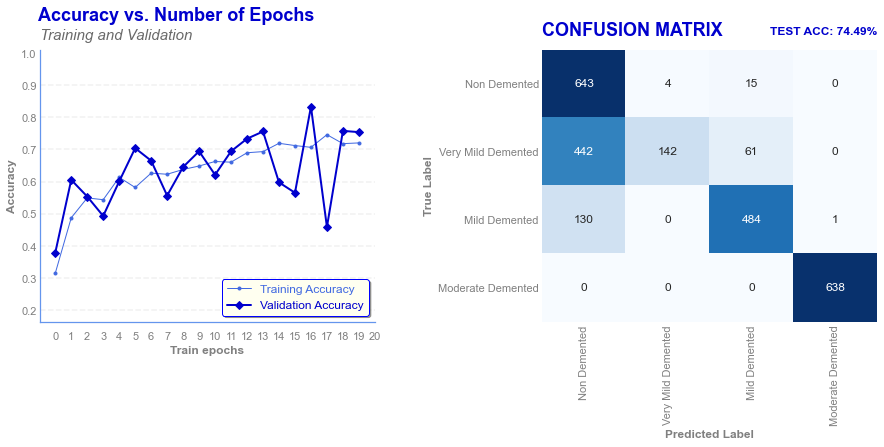

Experiment_1_PCA

Number of Epochs: 20
Activation function: sigmoid
Optimizer: SGD
Learning Rate: 0.01


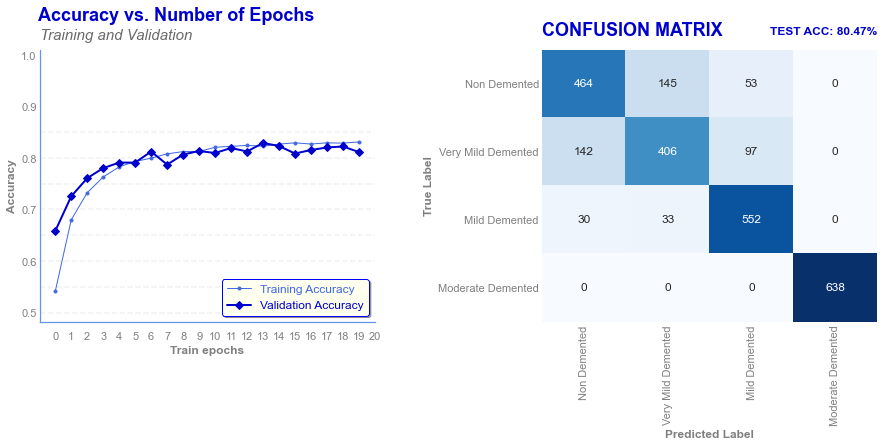

Experiment_2

Number of Epochs: 20
Activation function: sigmoid
Optimizer: SGD
Learning Rate: 0.001


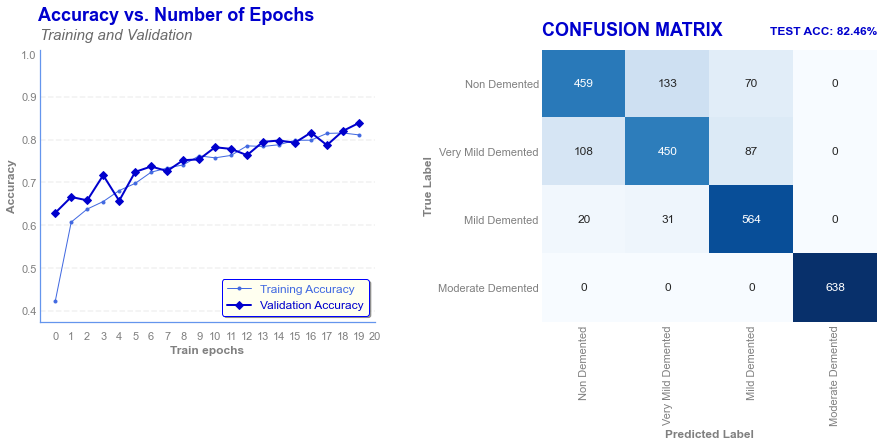

Experiment_2_PCA

Number of Epochs: 20
Activation function: sigmoid
Optimizer: SGD
Learning Rate: 0.001


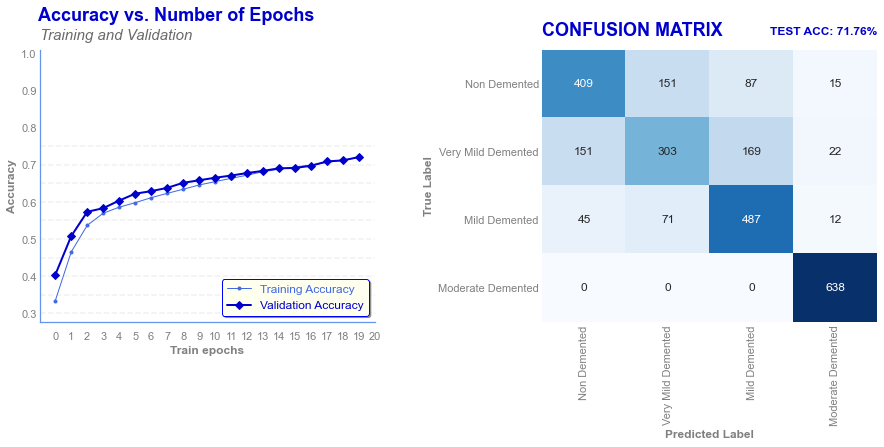

Experiment_3

Number of Epochs: 20
Activation function: softmax
Optimizer: SGD
Learning Rate: 0.01


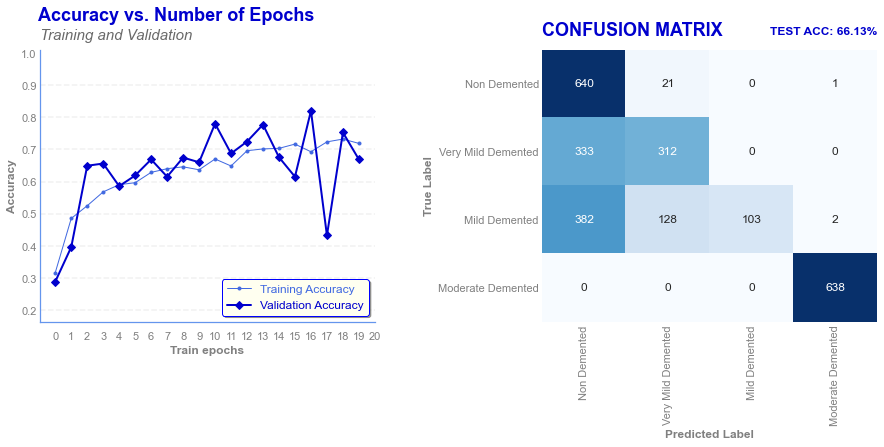

Experiment_3_PCA

Number of Epochs: 20
Activation function: softmax
Optimizer: SGD
Learning Rate: 0.01


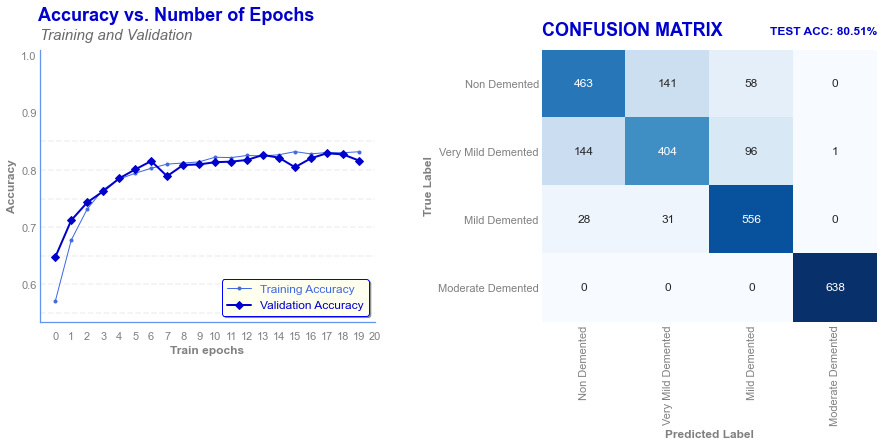

Experiment_4

Number of Epochs: 20
Activation function: softmax
Optimizer: SGD
Learning Rate: 0.001


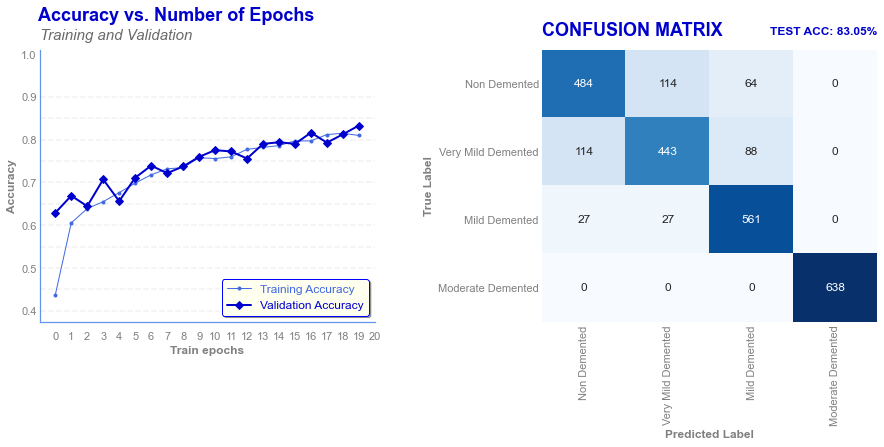

Experiment_4_PCA

Number of Epochs: 20
Activation function: softmax
Optimizer: SGD
Learning Rate: 0.001


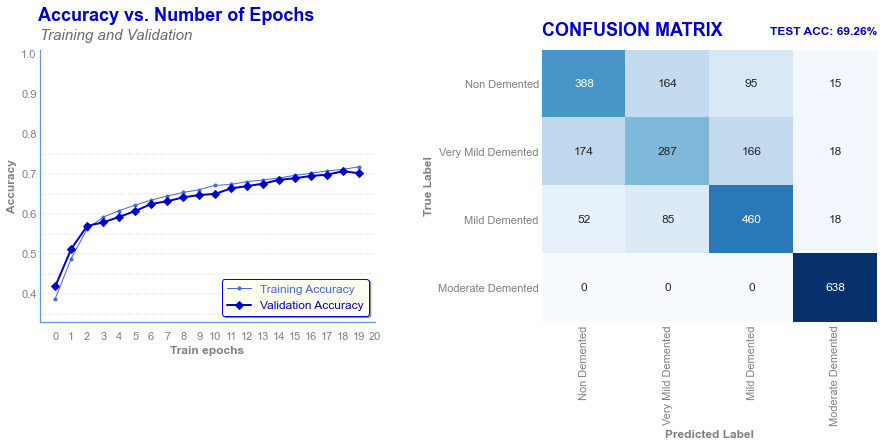

In [18]:
for i in range (1,len(experiments_lrdf.index)+1):
    print('Experiment_' + str(i) + '\n')
    accu, param = train_and_evaluate_logreg(X_train, Y_train, X_test, Y_test,
                                            activation = experiments_lrdf.loc['Experiment_' + str(i), 'ACTIVATION'], 
                                            optimizer = experiments_lrdf.loc['Experiment_' + str(i), 'OPTIMIZER'], 
                                            learning_rate = experiments_lrdf.loc['Experiment_' + str(i), 'LEARNING RATE'])

    experiments_lrdf.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_lrdf.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    
    print('Experiment_' + str(i) + '_PCA\n')
    accu_pca, param_pca = train_and_evaluate_logreg(X_train_pca, Y_train, X_test_pca, Y_test,
                                            activation = experiments_lrdf.loc['Experiment_' + str(i), 'ACTIVATION'], 
                                            optimizer = experiments_lrdf.loc['Experiment_' + str(i), 'OPTIMIZER'], 
                                            learning_rate = experiments_lrdf.loc['Experiment_' + str(i), 'LEARNING RATE'])

    experiments_lrdf.loc['Experiment_' + str(i), '# PARAMETERS (PCA)'] = param_pca
    experiments_lrdf.loc['Experiment_' + str(i), 'TEST ACCURACY (PCA)'] = accu_pca

In [19]:
experiments_lrdf

ACTIVATION OPTIMIZER  LEARNING RATE  EPOCHS  # PARAMETERS  \
Experiment_1    sigmoid       SGD          0.010      20        196612   
Experiment_2    sigmoid       SGD          0.001      20        196612   
Experiment_3    softmax       SGD          0.010      20        196612   
Experiment_4    softmax       SGD          0.001      20        196612   

              TEST ACCURACY  # PARAMETERS (PCA)  TEST ACCURACY (PCA)  
Experiment_1       0.744922                 904             0.804688  
Experiment_2       0.824609                 904             0.717578  
Experiment_3       0.661328                 904             0.805078  
Experiment_4       0.830469                 904             0.692578

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">K-Means Clustering</div>

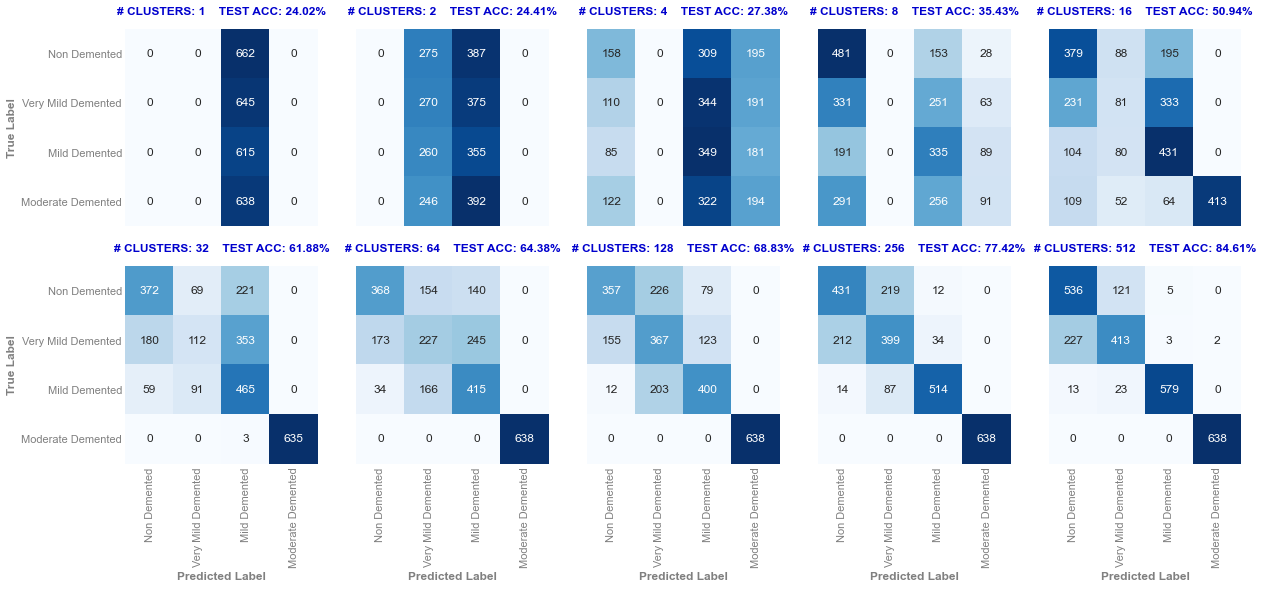

# CLUSTERS  TRAIN ACCURACY  TEST ACCURACY
Experiment_1          1.0        0.252441       0.240234
Experiment_2          2.0        0.255664       0.244141
Experiment_3          4.0        0.287598       0.273828
Experiment_4          8.0        0.353613       0.354297
Experiment_5         16.0        0.523828       0.509375
Experiment_6         32.0        0.625781       0.618750
Experiment_7         64.0        0.652051       0.643750
Experiment_8        128.0        0.705762       0.688281
Experiment_9        256.0        0.799316       0.774219
Experiment_10       512.0        0.886035       0.846094

In [20]:
def kmean_models(init_clusters,  
                 x_train, 
                 y_train,
                 x_test,
                 y_test):
    
    totl_rows = 2
    totl_cols = 5
    
    exp_ind = ['Experiment_' + str(i) for i in range(1,(totl_rows * totl_cols)+1)]
    kmean_df = pd.DataFrame(index = exp_ind)

    fig, axs = plt.subplots(nrows = totl_rows, ncols = totl_cols, figsize = (20, 8))

    for i in range(0, totl_rows * totl_cols):
        row = math.trunc(i/totl_cols)
        col = i%totl_cols

        num_clusters = init_clusters ** (i)

        kmean = KMeans(n_clusters = num_clusters, 
                       init = 'k-means++',
                       random_state = 0)

        kmean.fit(X_train_pca, Y_train)

        kmean_train = kmean.predict(X_train_pca)

        kmean_translator = pd.DataFrame({'CLUSTER': kmean_train, 
                                         'LABEL': Y_train})

        translator = pd.Series.tolist(kmean_translator.groupby(['CLUSTER']).agg(pd.Series.mode)['LABEL'])
        
        kmean_train_pred = kmean.predict(X_train_pca)
        kmean_train_pred = pd.Series(kmean_train_pred)
        kmean_train_pred = kmean_train_pred.replace(range(0, num_clusters), translator)
        train_acc = sum(kmean_train_pred == Y_train)/len(Y_train)
        
        kmean_predictions = kmean.predict(X_test_pca)
        kmean_predictions = pd.Series(kmean_predictions)
        kmean_predictions = kmean_predictions.replace(range(0, num_clusters), translator)
        test_acc = sum(kmean_predictions == Y_test)/len(Y_test)

        kmean_confusion_matrix = tf.math.confusion_matrix(Y_test, kmean_predictions)

        sns.heatmap(ax = axs[row][col], data = kmean_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                        xticklabels = (label_names if row + 1 == totl_rows else 'auto'), 
                        yticklabels = (label_names if col == 0 else 'auto'), cbar=False)

        # Add axis labels.
        if row + 1 == totl_rows:
            axs[row][col].set_xlabel('Predicted Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='x', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_xticks([])

        if col == 0:
            axs[row][col].set_ylabel('True Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='y', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_yticks([])

        axs[row][col].set_title("# CLUSTERS: " + str(num_clusters) + '    TEST ACC: ' + str(round(test_acc*100,2)) + '%', 
                                    weight='bold', color = 'mediumblue', pad=14, loc='center', size=12)
        
        kmean_df.loc['Experiment_' + str(i + 1), '# CLUSTERS'] = num_clusters
        kmean_df.loc['Experiment_' + str(i + 1), 'TRAIN ACCURACY'] = train_acc
        kmean_df.loc['Experiment_' + str(i + 1), 'TEST ACCURACY'] = test_acc

    plt.show()

    return kmean_df

## Plot accuracies vs. k values
experiments_kmean_df = kmean_models(2, X_train_pca, Y_train, X_test_pca, Y_test)

experiments_kmean_df

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Nearest Neighbors </div>

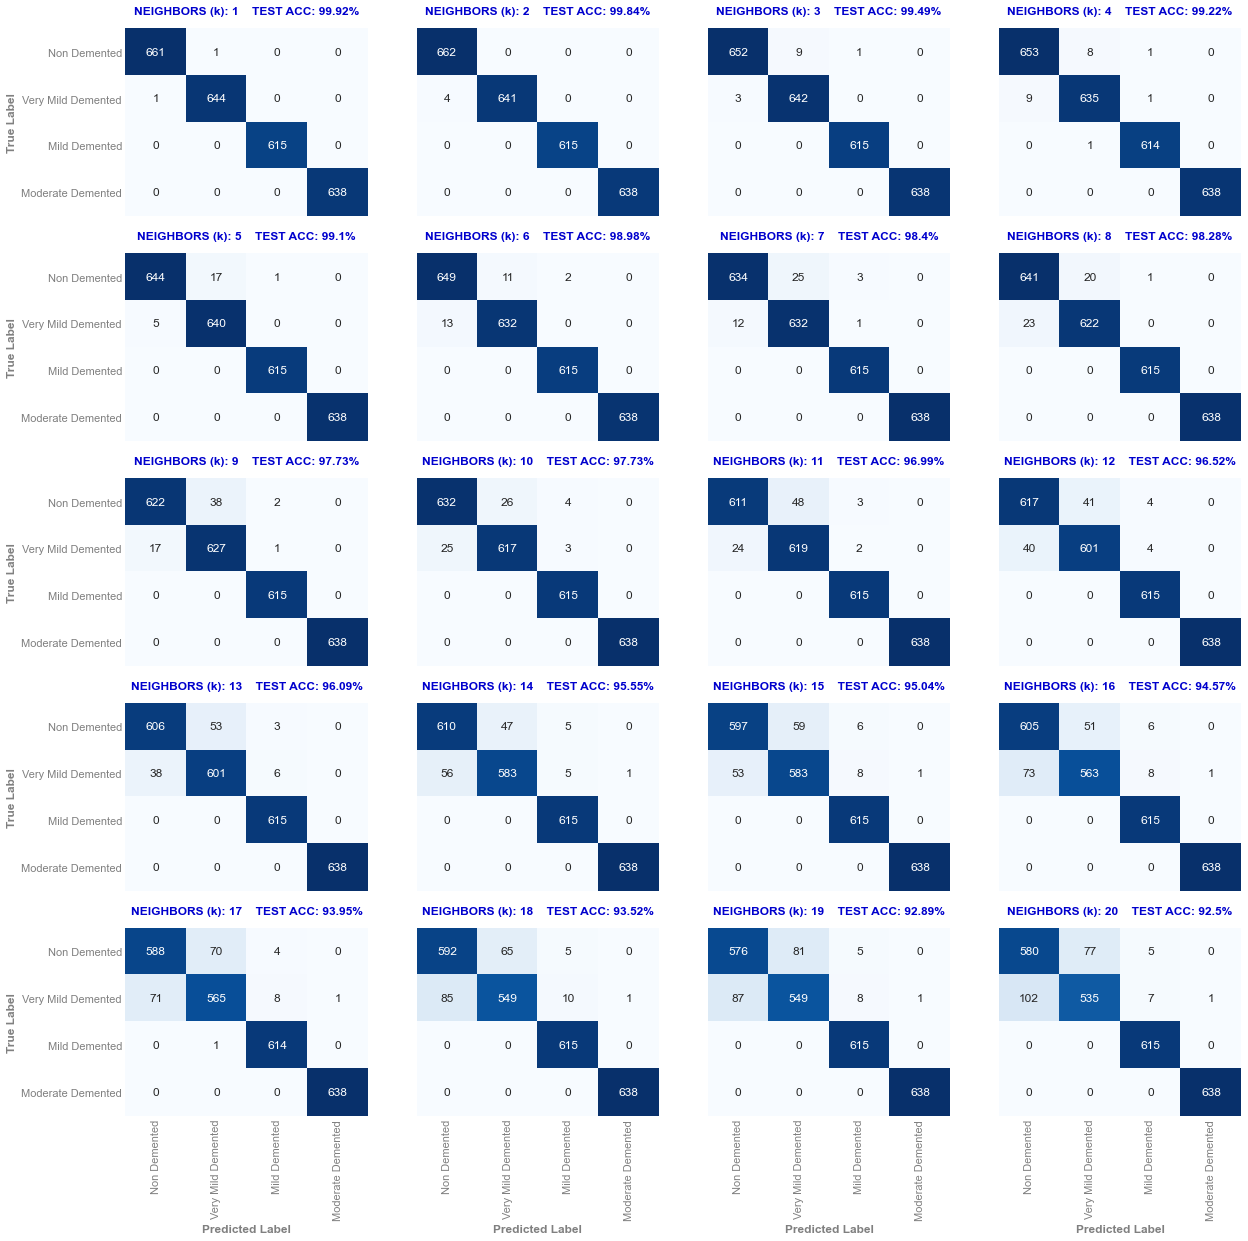

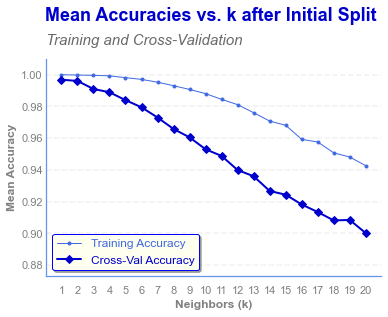

NEIGHBORS (k)  CV ACCURACY  TRAIN ACCURACY  TEST ACCURACY
Experiment_1             1.0     0.996875        1.000000       0.999219
Experiment_2             2.0     0.996094        0.999805       0.998437
Experiment_3             3.0     0.991016        0.999609       0.994922
Experiment_4             4.0     0.988965        0.999316       0.992188
Experiment_5             5.0     0.983984        0.998145       0.991016
Experiment_6             6.0     0.979492        0.997070       0.989844
Experiment_7             7.0     0.973047        0.995313       0.983984
Experiment_8             8.0     0.965820        0.993066       0.982812
Experiment_9             9.0     0.960547        0.990723       0.977344
Experiment_10           10.0     0.953027        0.988086       0.977344
Experiment_11           11.0     0.948828        0.984473       0.969922
Experiment_12           12.0     0.939941        0.981152       0.965234
Experiment_13           13.0     0.936035        0.976074       0.960938
Experiment_14           14.0     0.926758        0.970801       0.955469
Experiment_15           15.0     0.924414        0.968164       0.950391
Experiment_16           16.0     0.918262        0.959277       0.945703
Experiment_17           17.0     0.913477        0.957617       0.939453
Experiment_18           18.0     0.908203        0.950781       0.935156
Experiment_19           19.0     0.908496        0.948145       0.928906
Experiment_20           20.0     0.900195        0.942676       0.925000

In [21]:
## Create helper function for plotting the training accuracy vs. 
## cross-validation accuracy plot with various depths
def knn_acc_plot(start: int, 
                 end: int, 
                 x_train, 
                 y_train,
                 x_test,
                 y_test):
    ## Set k range and initialize df
    k_range = range(start, end)
    exp_ind = ['Experiment_' + str(i) for i in range(1,end-start+1)]
    knn_df = pd.DataFrame(index = exp_ind)
    totl_cols = 4
    totl_rows = math.ceil((end-start-1)/totl_cols)
    
    fig, axs = plt.subplots(nrows = totl_rows, ncols= totl_cols, figsize = (5 * totl_cols, 4 * totl_rows))
    i = 0
    
    for k in k_range:
        row = math.trunc(i/totl_cols)
        col = i%totl_cols
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(x_train, y_train)
        accuracy = knn.score(x_train, y_train)
        scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
        test_accuracy = knn.score(x_test, y_test)
        knn_predictions = knn.predict(x_test)
        knn_confusion_matrix = tf.math.confusion_matrix(y_test, knn_predictions)
        
        sns.heatmap(ax = axs[row][col], data = knn_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                    xticklabels = (label_names if row + 1 == totl_rows else 'auto'), 
                    yticklabels = (label_names if col == 0 else 'auto'), cbar=False)

        # Add axis labels.
        if row + 1 == totl_rows:
            axs[row][col].set_xlabel('Predicted Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='x', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_xticks([])
            
        if col == 0:
            axs[row][col].set_ylabel('True Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='y', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_yticks([])
        
        axs[row][col].set_title("NEIGHBORS (k): " + str(k) + '    TEST ACC: ' + str(round(test_accuracy*100,2)) + '%', 
                                weight='bold', color = 'mediumblue', pad=14, loc='center', size=12)
        
        knn_df.loc['Experiment_' + str(i + 1), 'NEIGHBORS (k)'] = k
        knn_df.loc['Experiment_' + str(i + 1), 'CV ACCURACY'] = scores.mean()
        knn_df.loc['Experiment_' + str(i + 1), 'TRAIN ACCURACY'] = accuracy.mean()
        knn_df.loc['Experiment_' + str(i + 1), 'TEST ACCURACY'] = test_accuracy
        
        i += 1
    plt.show()

    ## Plot mean CV accuracies for k
    ax = plt.axes()
    plt.plot(k_range, knn_df['TRAIN ACCURACY'], label = "Training Accuracy", 
         color = 'royalblue', marker = '.', lw = 1)
    plt.plot(k_range, knn_df['CV ACCURACY'], label = "Cross-Val Accuracy", 
             color = 'mediumblue', marker = 'D', lw = 2)
    
    # Spine formatting
    ax.set_facecolor(color='white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('cornflowerblue')
    ax.spines['bottom'].set_color('cornflowerblue')
    
    # Tick formatting
    ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
    ax.tick_params(axis='x', which='both', colors = 'gray')
    ax.set_xticks(k_range)
    
    # Grid formatting
    ax.grid(False)
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)
    
    # Set title
    plt.suptitle("Mean Accuracies vs. k after Initial Split", x = 0.123, y = 1.06, 
                 ha = 'left', weight='bold', color = 'mediumblue', 
                 size = 18)

    # Set title
    ax.set_title("Training and Cross-Validation", weight='normal', color = 'dimgray', 
                 style = 'italic', pad=14, loc='left', size=15)
    
    ax.legend(loc = 3, fontsize = 'medium', 
              shadow = True,
              edgecolor = 'blue',
              labelcolor = ['royalblue','mediumblue'], 
              facecolor = 'ivory')
    
    ax.set_xlabel('Neighbors (k)', color = 'gray', weight = 'bold')
    ax.set_ylabel('Mean Accuracy', color = 'gray', weight = 'bold')
    ax.set_ylim(top = 1.01)
    plt.show()
    
    return knn_df

## Plot accuracies vs. k values
experiments_knn_df = knn_acc_plot(1, 21, X_train_pca, Y_train, X_test_pca, Y_test)

experiments_knn_df

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Decision Trees</div>

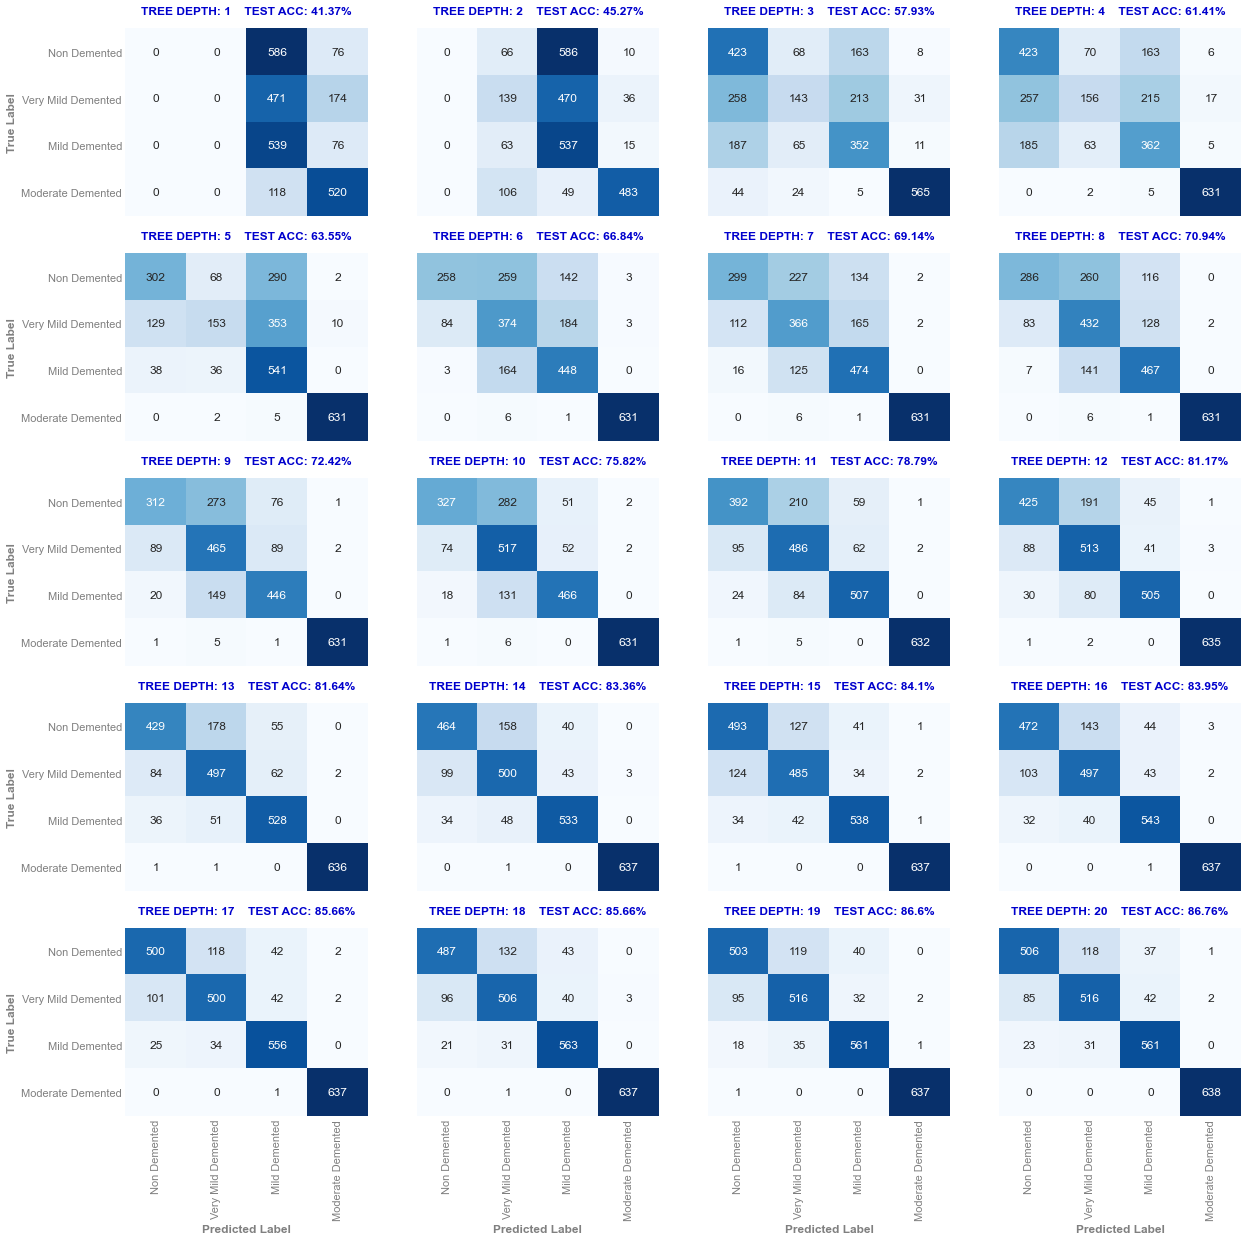

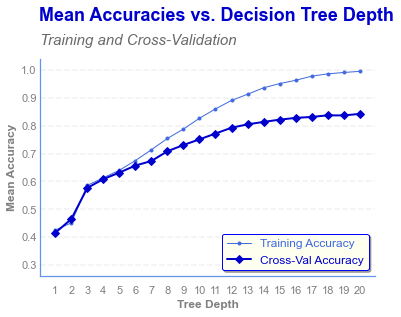

MAX DEPTH  CV ACCURACY  TRAIN ACCURACY  TEST ACCURACY
Experiment_1         1.0     0.415723        0.425684       0.413672
Experiment_2         2.0     0.465234        0.451367       0.452734
Experiment_3         3.0     0.576953        0.586035       0.579297
Experiment_4         4.0     0.608398        0.613281       0.614062
Experiment_5         5.0     0.631836        0.640137       0.635547
Experiment_6         6.0     0.657031        0.674902       0.668359
Experiment_7         7.0     0.673438        0.713770       0.691406
Experiment_8         8.0     0.708301        0.754395       0.709375
Experiment_9         9.0     0.730762        0.787891       0.724219
Experiment_10       10.0     0.750977        0.826855       0.758203
Experiment_11       11.0     0.771973        0.860254       0.787891
Experiment_12       12.0     0.792676        0.890625       0.811719
Experiment_13       13.0     0.804883        0.912793       0.816406
Experiment_14       14.0     0.813574        0.935937       0.833594
Experiment_15       15.0     0.821680        0.950977       0.841016
Experiment_16       16.0     0.828027        0.962793       0.839453
Experiment_17       17.0     0.831348        0.977637       0.856641
Experiment_18       18.0     0.837207        0.985938       0.856641
Experiment_19       19.0     0.836816        0.990918       0.866016
Experiment_20       20.0     0.842383        0.994922       0.867578

In [22]:
## Create helper function for plotting the training accuracy vs. 
## cross-validation accuracy plot with various depths
def dt_acc_plot(start: int, 
                end: int, 
                x_train, 
                y_train,
                x_test,
                y_test):
    ## Set depth range and initialize lists
    t_depth = range(start, end)
    exp_ind = ['Experiment_' + str(i) for i in range(1,end-start+1)]
    tree_df = pd.DataFrame(index = exp_ind)
    totl_cols = 4
    totl_rows = math.ceil((end-start-1)/totl_cols)
    
    fig, axs = plt.subplots(nrows = totl_rows, ncols= totl_cols, figsize = (5 * totl_cols, 4 * totl_rows))
    i = 0
    
    for lvl in t_depth:
        row = math.trunc(i/totl_cols)
        col = i%totl_cols
        dtree = tree.DecisionTreeClassifier(random_state = 0, max_depth = lvl)
        dtree.fit(x_train, y_train)
        accuracy = dtree.score(x_train, y_train)
        scores = cross_val_score(dtree, x_train, y_train, cv=5, scoring='accuracy')
        test_accuracy = dtree.score(x_test, y_test)
        tree_predictions = dtree.predict(x_test)
        tree_confusion_matrix = tf.math.confusion_matrix(y_test, tree_predictions)
        
        sns.heatmap(ax = axs[row][col], data = tree_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                    xticklabels = (label_names if row + 1 == totl_rows else 'auto'), 
                    yticklabels = (label_names if col == 0 else 'auto'), cbar=False)

        # Add axis labels.
        if row + 1 == totl_rows:
            axs[row][col].set_xlabel('Predicted Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='x', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_xticks([])
            
        if col == 0:
            axs[row][col].set_ylabel('True Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='y', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_yticks([])
        
        axs[row][col].set_title("TREE DEPTH: " + str(lvl) + '    TEST ACC: ' + str(round(test_accuracy*100,2)) + '%', 
                                weight='bold', color = 'mediumblue', pad=14, loc='center', size=12)
        
        tree_df.loc['Experiment_' + str(i + 1), 'MAX DEPTH'] = lvl
        tree_df.loc['Experiment_' + str(i + 1), 'CV ACCURACY'] = scores.mean()
        tree_df.loc['Experiment_' + str(i + 1), 'TRAIN ACCURACY'] = accuracy.mean()
        tree_df.loc['Experiment_' + str(i + 1), 'TEST ACCURACY'] = test_accuracy
        
        i += 1
    plt.show()
    
    ## Plot mean CV accuracies for Tree Depth
    ax = plt.axes()
    plt.plot(t_depth, tree_df['TRAIN ACCURACY'], label = "Training Accuracy", 
         color = 'royalblue', marker = '.', lw = 1)
    plt.plot(t_depth, tree_df['CV ACCURACY'], label = "Cross-Val Accuracy", 
             color = 'mediumblue', marker = 'D', lw = 2)
    
    # Spine formatting
    ax.set_facecolor(color='white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('cornflowerblue')
    ax.spines['bottom'].set_color('cornflowerblue')
    
    # Tick formatting
    ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
    ax.tick_params(axis='x', which='both', colors = 'gray')
    ax.set_xticks(t_depth)
    
    # Grid formatting
    ax.grid(False)
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)
    
    # Set title
    plt.suptitle("Mean Accuracies vs. Decision Tree Depth", x = 0.123, y = 1.06, 
                 ha = 'left', weight='bold', color = 'mediumblue', 
                 size = 18)

    # Set title
    ax.set_title("Training and Cross-Validation", weight='normal', color = 'dimgray', 
                 style = 'italic', pad=14, loc='left', size=15)
    
    ax.legend(loc = 4, fontsize = 'medium', 
              shadow = True,
              edgecolor = 'blue',
              labelcolor = ['royalblue','mediumblue'], 
              facecolor = 'ivory')
    
    ax.set_xlabel('Tree Depth', color = 'gray', weight = 'bold')
    ax.set_ylabel('Mean Accuracy', color = 'gray', weight = 'bold')
    ax.set_ylim(top = 1.04)
    plt.show()
    
    return tree_df

## Plot accuracies vs. k values
experiments_tree_df = dt_acc_plot(1, 21, X_train_pca, Y_train, X_test_pca, Y_test)

experiments_tree_df

TestAccuracy: 0.6355


[Text(0.5769230769230769, 0.9166666666666666, 'x[8] <= -1.228\ngini = 0.75\nsamples = 10240\nvalue = [2538, 2555, 2585, 2562]'),
 Text(0.3076923076923077, 0.75, 'x[4] <= 0.275\ngini = 0.559\nsamples = 3376\nvalue = [351, 577, 337, 2111]'),
 Text(0.15384615384615385, 0.5833333333333334, 'x[130] <= 0.475\ngini = 0.214\nsamples = 1875\nvalue = [47, 120, 51, 1657]'),
 Text(0.07692307692307693, 0.4166666666666667, 'x[80] <= -0.635\ngini = 0.119\nsamples = 1767\nvalue = [30, 53, 27, 1657]'),
 Text(0.038461538461538464, 0.25, 'x[24] <= 2.244\ngini = 0.592\nsamples = 52\nvalue = [16, 28, 8, 0]'),
 Text(0.019230769230769232, 0.08333333333333333, 'gini = 0.478\nsamples = 44\nvalue = [15, 28, 1, 0]'),
 Text(0.057692307692307696, 0.08333333333333333, 'gini = 0.219\nsamples = 8\nvalue = [1, 0, 7, 0]'),
 Text(0.11538461538461539, 0.25, 'x[221] <= 0.458\ngini = 0.066\nsamples = 1715\nvalue = [14, 25, 19, 1657]'),
 Text(0.09615384615384616, 0.08333333333333333, 'gini = 0.029\nsamples = 1682\nvalue = [

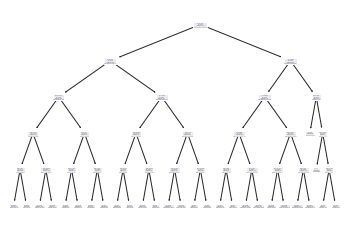

In [23]:
# UNCOMMENT THIS TO GET A PICTURE OF THE TREE

dtree = tree.DecisionTreeClassifier(random_state = 0, max_depth = 5)
dtree.fit(X_train_pca, Y_train)

tree_predictions = dtree.predict(X_test_pca)

print('TestAccuracy: %1.4f' %dtree.score(X_test_pca, Y_test))

tree.plot_tree(dtree)

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Random Forest</div>

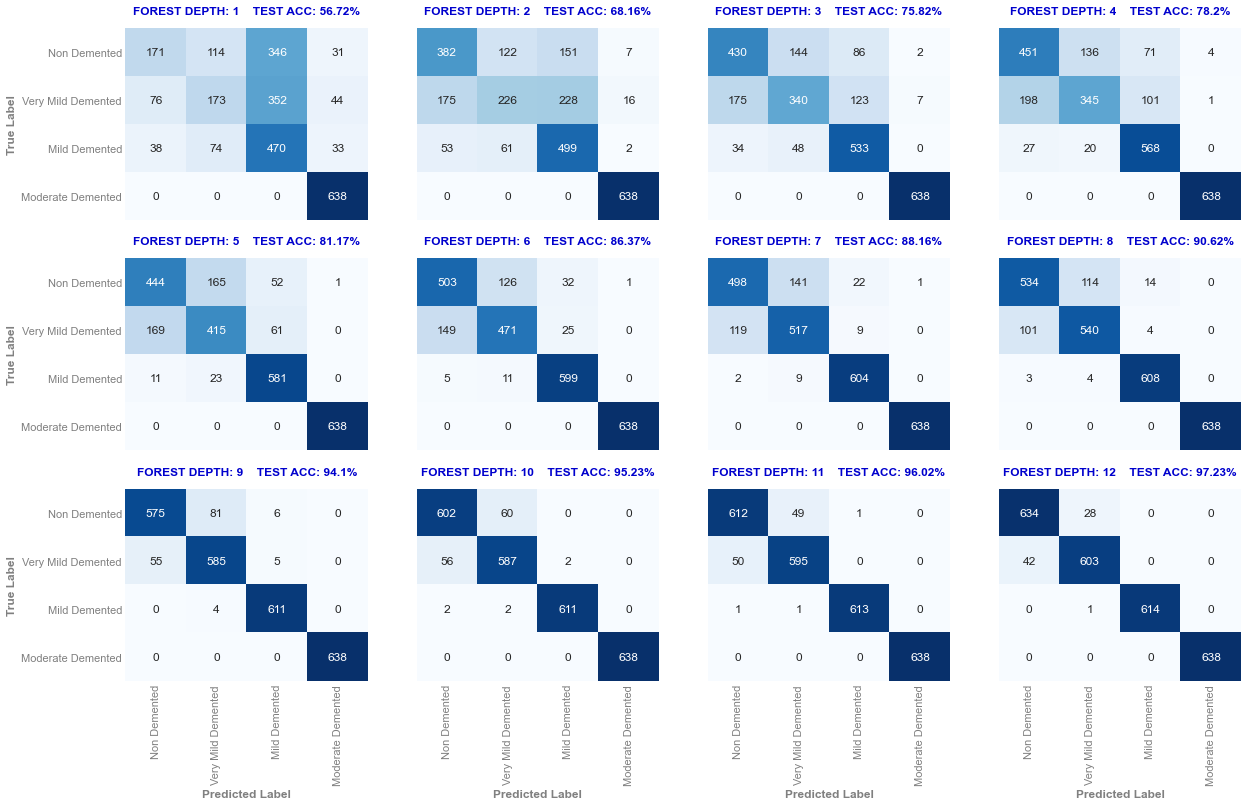

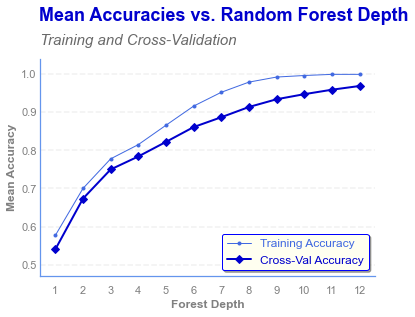

MAX DEPTH  CV ACCURACY  TRAIN ACCURACY  TEST ACCURACY
Experiment_1         1.0     0.540332        0.576855       0.567187
Experiment_2         2.0     0.673438        0.700098       0.681641
Experiment_3         3.0     0.749902        0.777734       0.758203
Experiment_4         4.0     0.783984        0.815039       0.782031
Experiment_5         5.0     0.822168        0.865820       0.811719
Experiment_6         6.0     0.861035        0.916016       0.863672
Experiment_7         7.0     0.886816        0.952246       0.881641
Experiment_8         8.0     0.913672        0.978906       0.906250
Experiment_9         9.0     0.933984        0.992188       0.941016
Experiment_10       10.0     0.947266        0.996191       0.952344
Experiment_11       11.0     0.958984        0.999219       0.960156
Experiment_12       12.0     0.968750        0.999219       0.972266

In [24]:
# Create helper function for plotting the training accuracy vs. 
## cross-validation accuracy plot with various depths
def rf_acc_plot(start: int, 
                end: int, 
                x_train, 
                y_train,
                x_test,
                y_test):
    ## Set depth range and initialize lists
    rf_depth = range(start, end)
    tree_scores = []
    train_acc = []
    test_acc = []
    exp_ind = ['Experiment_' + str(i) for i in range(1,end-start+1)]
    rfor_df = pd.DataFrame(index = exp_ind)
    totl_cols = 4
    totl_rows = math.ceil((end-start-1)/totl_cols)
    
    fig, axs = plt.subplots(nrows = totl_rows, ncols= totl_cols, figsize = (5 * totl_cols, 4 * totl_rows))
    i = 0
    
    for lvl in rf_depth:
        row = math.trunc(i/totl_cols)
        col = i%totl_cols
        rfor = RandomForestClassifier(random_state = 0, max_depth = lvl)
        rfor.fit(x_train, y_train)
        accuracy = rfor.score(x_train, y_train)
        scores = cross_val_score(rfor, x_train, y_train, cv = 5, scoring='accuracy')
        test_accuracy = rfor.score(x_test, y_test)
        forest_predictions = rfor.predict(x_test)
        forest_confusion_matrix = tf.math.confusion_matrix(y_test, forest_predictions)
        
        sns.heatmap(ax = axs[row][col], data = forest_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                    xticklabels = (label_names if row + 1 == totl_rows else 'auto'), 
                    yticklabels = (label_names if col == 0 else 'auto'), cbar=False)

        # Add axis labels.
        if row + 1 == totl_rows:
            axs[row][col].set_xlabel('Predicted Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='x', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_xticks([])
            
        if col == 0:
            axs[row][col].set_ylabel('True Label', color = 'gray', weight = 'bold')
            axs[row][col].tick_params(axis='y', which='both', length=0, colors = 'gray')
        else:
            axs[row][col].set_yticks([])
        
        axs[row][col].set_title("FOREST DEPTH: " + str(lvl) + '    TEST ACC: ' + str(round(test_accuracy*100,2)) + '%', 
                                weight='bold', color = 'mediumblue', pad=14, loc='center', size=12)
        
        rfor_df.loc['Experiment_' + str(i + 1), 'MAX DEPTH'] = lvl
        rfor_df.loc['Experiment_' + str(i + 1), 'CV ACCURACY'] = scores.mean()
        rfor_df.loc['Experiment_' + str(i + 1), 'TRAIN ACCURACY'] = accuracy.mean()
        rfor_df.loc['Experiment_' + str(i + 1), 'TEST ACCURACY'] = test_accuracy
        
        i += 1
    plt.show()
    
    ## Plot mean CV accuracies for depth
    
    ax = plt.axes()
    plt.plot(rf_depth, rfor_df['TRAIN ACCURACY'], label = "Training Accuracy", 
         color = 'royalblue', marker = '.', lw = 1)
    plt.plot(rf_depth, rfor_df['CV ACCURACY'], label = "Cross-Val Accuracy", 
             color = 'mediumblue', marker = 'D', lw = 2)
    
    # Spine formatting
    ax.set_facecolor(color='white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('cornflowerblue')
    ax.spines['bottom'].set_color('cornflowerblue')
    
    # Tick formatting
    ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
    ax.tick_params(axis='x', which='both', colors = 'gray')
    ax.set_xticks(rf_depth)
    
    # Grid formatting
    ax.grid(False)
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)
    
    # Set title
    plt.suptitle("Mean Accuracies vs. Random Forest Depth", x = 0.123, y = 1.06, 
                 ha = 'left', weight='bold', color = 'mediumblue', 
                 size = 18)

    # Set title
    ax.set_title("Training and Cross-Validation", weight='normal', color = 'dimgray', 
                 style = 'italic', pad=14, loc='left', size=15)
    
    ax.legend(loc = 4, fontsize = 'medium', 
              shadow = True,
              edgecolor = 'blue',
              labelcolor = ['royalblue','mediumblue'], 
              facecolor = 'ivory')
    
    ax.set_xlabel('Forest Depth', color = 'gray', weight = 'bold')
    ax.set_ylabel('Mean Accuracy', color = 'gray', weight = 'bold')
    ax.set_ylim(top = 1.04)
    plt.show()
    
    return rfor_df

## Plot accuracies vs. k values
experiments_rfor_df = rf_acc_plot(1, 13, X_train_pca, Y_train, X_test_pca, Y_test)

experiments_rfor_df

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Neural Networks </div>

In [25]:
#Neural network with hidden layers

def build_nn_model(n_classes,
                   hidden_layer_sizes=[],
                   activation='relu',
                   optimizer='SGD',
                   learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
        n_classes: Number of output classes in the dataset.
        hidden_layer_sizes: A list with the number of units in each hidden layer.
        activation: The activation function to use for the hidden layers.
        optimizer: The optimizer to use (SGD, Adam).
        learning_rate: The desired learning rate for the optimizer.

    Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(5678)
    tf.random.set_seed(5678)
    random.seed(5678)

    model = tf.keras.Sequential()

    # flatten the 128x128x3 images into 1-D vectors
    model.add(keras.layers.Flatten())
  
    # add the specified hidden layers with the specified activation
    i = 1
    for hidden_layer_size in hidden_layer_sizes:
        lay_name = 'Hidden_' + str(i)
        model.add(tf.keras.layers.Dense(units = hidden_layer_size,
                                        activation = activation,
                                        name = lay_name))
        print('Hidden Layer ' + str(i) + ' size: ' + str(hidden_layer_size))
        i += 1
  
    #Output layer. Since we are doing multi-class classification, use softmax for the activation
    model.add(tf.keras.layers.Dense(units = n_classes,
                                    activation = 'softmax',
                                    name = 'Output'))
    
    print('Activation function: ' + activation)

    if optimizer == 'SGD':
        model_opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
        print('Optimizer: SGD')
    elif optimizer == 'Adam':
        model_opt = keras.optimizers.Adam(learning_rate = learning_rate)
        print('Optimizer: Adam')
    else:
        model_opt = optimizer
        print('Optimizer: ' + optimizer)
        
    print('Learning Rate: ' + str(learning_rate))

    model.compile(loss='sparse_categorical_crossentropy', optimizer = model_opt, metrics=['accuracy'])

    return model


In [26]:
def train_and_evaluate_nn(x_train,
                          y_train,
                          x_test,
                          y_test,
                          hidden_layer_sizes=[],
                          activation='relu',
                          optimizer='Adam',
                          learning_rate=0.01,
                          num_epochs=20, 
                          verb = False):

    # Build the model.
    model = build_nn_model(n_classes=4,
                           hidden_layer_sizes=hidden_layer_sizes,
                           activation=activation,
                           optimizer=optimizer,
                           learning_rate=learning_rate)

    # Train the model.
    history = model.fit(
        x = x_train,
        y = y_train,
        epochs = num_epochs,
        batch_size = 64, 
        verbose = verb,
        validation_split = 0.1)

    model.summary()

    # Retrieve the training metrics (after each train epoch) and the final test
    # accuracy.
    hist = history.history
    train_accuracy = hist['accuracy']
    val_accuracy = hist['val_accuracy']
    
    test_accuracy = model.evaluate(x = x_test, y = y_test, verbose = verb,
                                   return_dict=True)['accuracy']

    num_params = model.count_params()

    test_predictions = np.argmax(model.predict(x_test, verbose = verb), axis=-1)
  
    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test, test_predictions)
    
    ## Plot mean CV accuracies for Tree Depth
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(train_accuracy, label = "Training Accuracy", 
         color = 'royalblue', marker = '.', lw = 1)
    ax.plot(val_accuracy, label = "Validation Accuracy", 
             color = 'mediumblue', marker = 'D', lw = 2)
    
    # Spine formatting
    ax.set_facecolor(color='white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('cornflowerblue')
    ax.spines['bottom'].set_color('cornflowerblue')
    
    # Tick formatting
    ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
    ax.tick_params(axis='x', which='both', colors = 'gray')
    ax.set_xticks(range(num_epochs + 1))
    
    # Grid formatting
    ax.grid(False)
    vals = ax.get_yticks()
    for tick in vals:
        ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)
    
    # Set title
    plt.suptitle("Accuracy vs. Number of Epochs", x = 0.123, y = 1, 
                 ha = 'left', weight='bold', color = 'mediumblue', 
                 size = 18)

    # Set title
    ax.set_title("Training and Validation", weight='normal', color = 'dimgray', 
                 style = 'italic', pad=10, loc='left', size=15)
    
    ax.legend(loc = 4, fontsize = 'medium', 
              shadow = True,
              edgecolor = 'blue',
              labelcolor = ['royalblue','mediumblue'], 
              facecolor = 'ivory')
    
    ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
    ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
    ax.set_ylim(top = 1.01)

    # Use a heatmap plot to display it.
    ax = fig.add_subplot(1, 2, 2)
    ax = sns.heatmap(confusion_matrix, annot = True, fmt = '.3g', cmap = 'Blues',
                     xticklabels = label_names, yticklabels = label_names, cbar = False)
    
    # Add axis labels.
    ax.tick_params(axis='x', which='both', length=0, colors = 'gray', rotation = 90)
    ax.set_xlabel('Predicted Label', color = 'gray', weight = 'bold')
    ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
    ax.set_ylabel('True Label', color = 'gray', weight = 'bold')

    ax.set_title('CONFUSION MATRIX', 
                 weight='bold', color = 'mediumblue', pad=14, loc='left', size=18)

    ax.text(x = 4, y = -0.22, ha = 'right',
            s = 'TEST ACC: ' + str(round(test_accuracy*100,2)) + '%',
            color = 'mediumblue', weight='bold')
    
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    
    metrics = compute_model_performance_metrics(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')

    return [test_accuracy, num_params, metrics]


In [27]:
# Generating a Dataframe with all the Neural Network experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
acts = (['relu'] + ['tanh']* 2 + ['relu'] * 3)
opts = (['Adam'] + ['SGD'] * 3 + ['Adam'] * 2)
sizes = [[]] + [[128]] + [[256 , 128]] + ([[128]]) * 2 + [[256 , 128]]
rates = [0.01] * 3 + [0.0001] + [0.001] + [0.0001]
epchs = [21] + [5] + [20] * 4
params = [0] * 6
accs = [0] * 6

experiments_nndf = pd.DataFrame({'ACTIVATION': acts, 
                                 'OPTIMIZER': opts, 
                                 'HIDDEN SIZES': sizes, 
                                 'LEARNING RATE': rates,
                                 'EPOCHS': epchs, 
                                 '# PARAMETERS': params,
                                 'TEST ACCURACY': accs, 
                                 '# PARAMETERS (PCA)': params,
                                 'TEST ACCURACY (PCA)': accs}, 
                                index = exp_ind)

Experiment_1

Activation function: relu
Optimizer: Adam
Learning Rate: 0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 49152)               0         
                                                                 
 Output (Dense)              (64, 4)                   196612    
                                                                 
Total params: 196,612
Trainable params: 196,612
Non-trainable params: 0
_________________________________________________________________


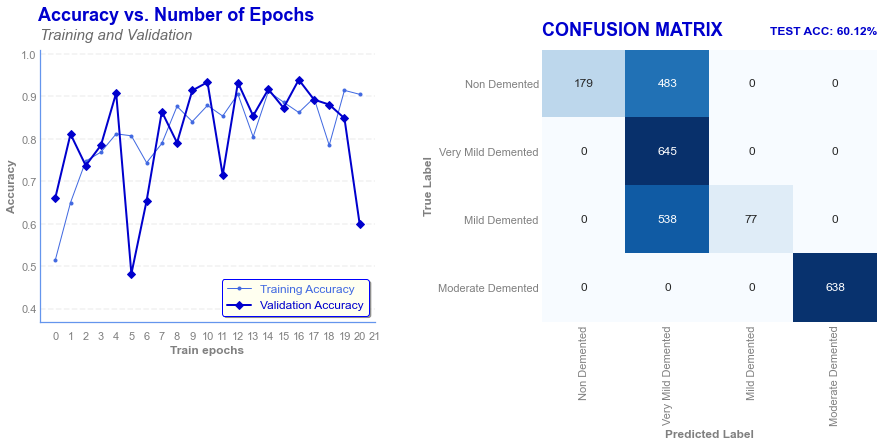

Experiment_1_PCA

Activation function: relu
Optimizer: Adam
Learning Rate: 0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 225)                 0         
                                                                 
 Output (Dense)              (64, 4)                   904       
                                                                 
Total params: 904
Trainable params: 904
Non-trainable params: 0
_________________________________________________________________


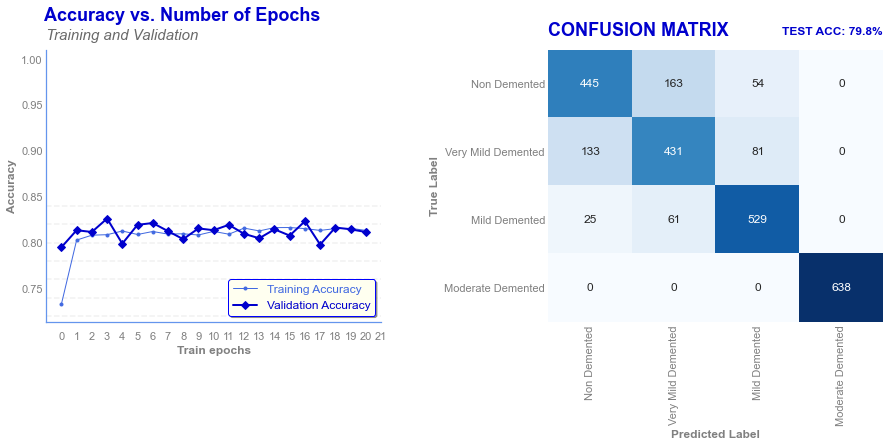

Experiment_2

Hidden Layer 1 size: 128
Activation function: tanh
Optimizer: SGD
Learning Rate: 0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 49152)               0         
                                                                 
 Hidden_1 (Dense)            (64, 128)                 6291584   
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 6,292,100
Trainable params: 6,292,100
Non-trainable params: 0
_________________________________________________________________


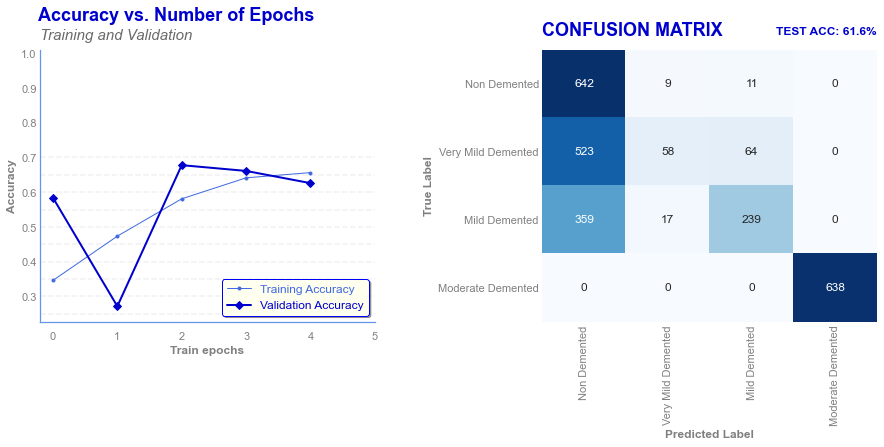

Experiment_2_PCA

Hidden Layer 1 size: 128
Activation function: tanh
Optimizer: SGD
Learning Rate: 0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 225)                 0         
                                                                 
 Hidden_1 (Dense)            (64, 128)                 28928     
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 29,444
Trainable params: 29,444
Non-trainable params: 0
_________________________________________________________________


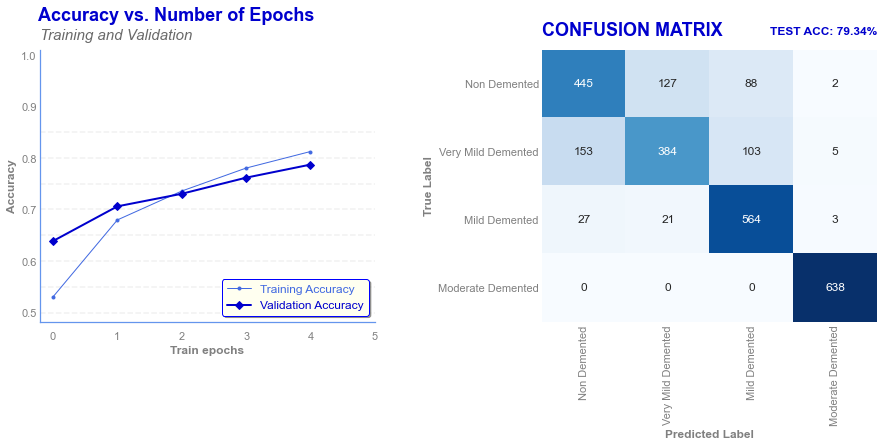

Experiment_3

Hidden Layer 1 size: 256
Hidden Layer 2 size: 128
Activation function: tanh
Optimizer: SGD
Learning Rate: 0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 49152)               0         
                                                                 
 Hidden_1 (Dense)            (64, 256)                 12583168  
                                                                 
 Hidden_2 (Dense)            (64, 128)                 32896     
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 12,616,580
Trainable params: 12,616,580
Non-trainable params: 0
_________________________________________________________________


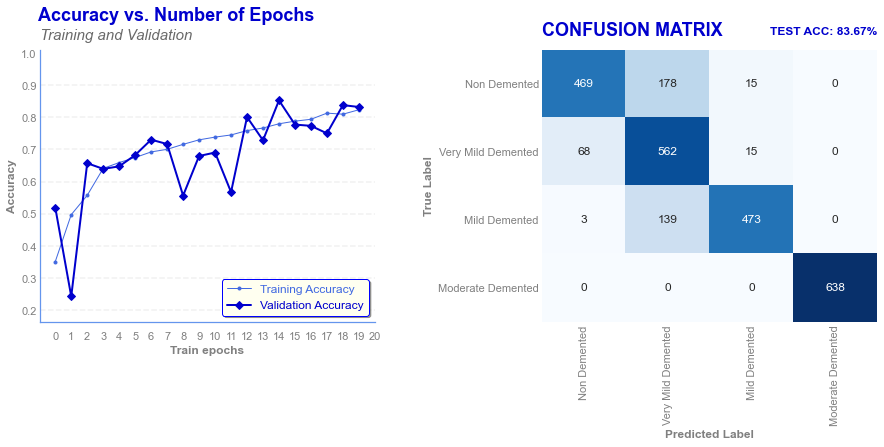

Experiment_3_PCA

Hidden Layer 1 size: 256
Hidden Layer 2 size: 128
Activation function: tanh
Optimizer: SGD
Learning Rate: 0.01
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 225)                 0         
                                                                 
 Hidden_1 (Dense)            (64, 256)                 57856     
                                                                 
 Hidden_2 (Dense)            (64, 128)                 32896     
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 91,268
Trainable params: 91,268
Non-trainable params: 0
_________________________________________________________________


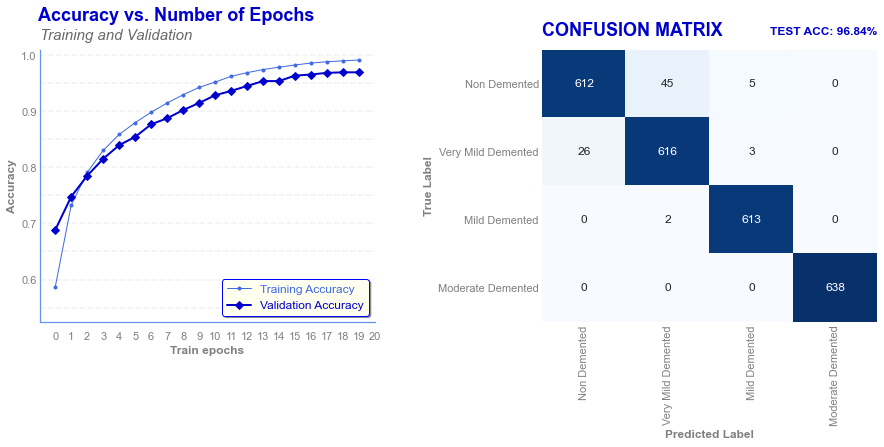

Experiment_4

Hidden Layer 1 size: 128
Activation function: relu
Optimizer: SGD
Learning Rate: 0.0001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 49152)               0         
                                                                 
 Hidden_1 (Dense)            (64, 128)                 6291584   
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 6,292,100
Trainable params: 6,292,100
Non-trainable params: 0
_________________________________________________________________


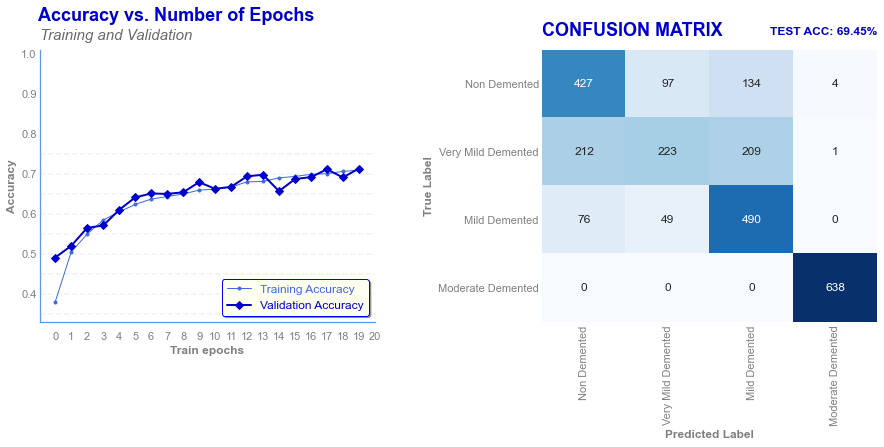

Experiment_4_PCA

Hidden Layer 1 size: 128
Activation function: relu
Optimizer: SGD
Learning Rate: 0.0001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 225)                 0         
                                                                 
 Hidden_1 (Dense)            (64, 128)                 28928     
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 29,444
Trainable params: 29,444
Non-trainable params: 0
_________________________________________________________________


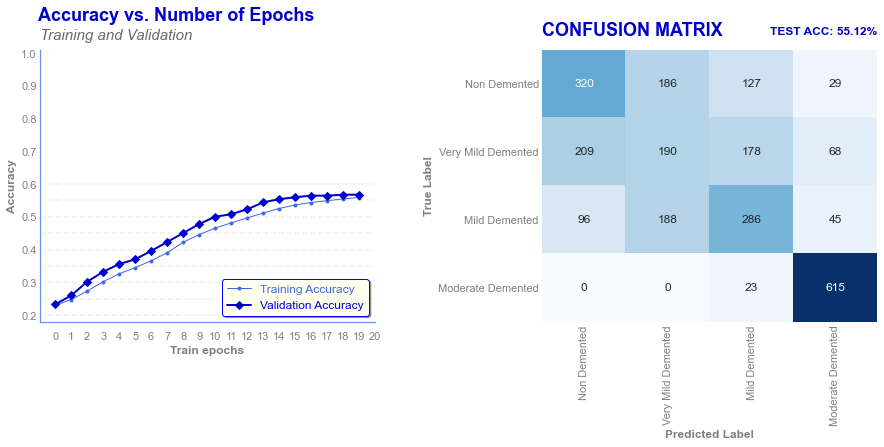

Experiment_5

Hidden Layer 1 size: 128
Activation function: relu
Optimizer: Adam
Learning Rate: 0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 49152)               0         
                                                                 
 Hidden_1 (Dense)            (64, 128)                 6291584   
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 6,292,100
Trainable params: 6,292,100
Non-trainable params: 0
_________________________________________________________________


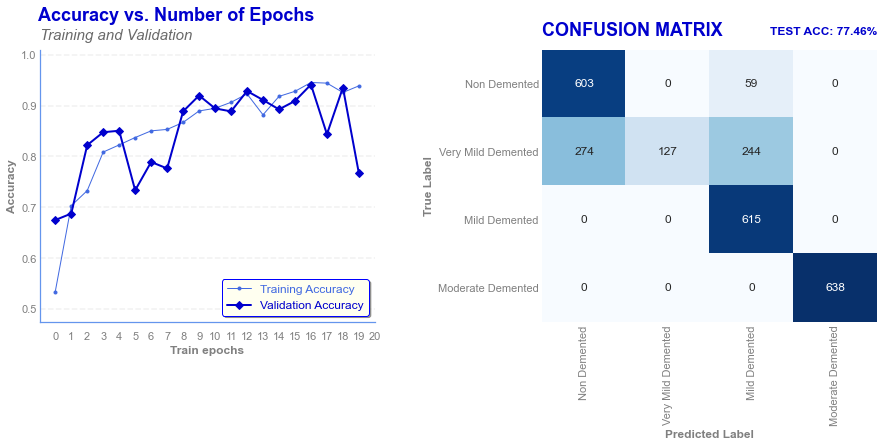

Experiment_5_PCA

Hidden Layer 1 size: 128
Activation function: relu
Optimizer: Adam
Learning Rate: 0.001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 225)                 0         
                                                                 
 Hidden_1 (Dense)            (64, 128)                 28928     
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 29,444
Trainable params: 29,444
Non-trainable params: 0
_________________________________________________________________


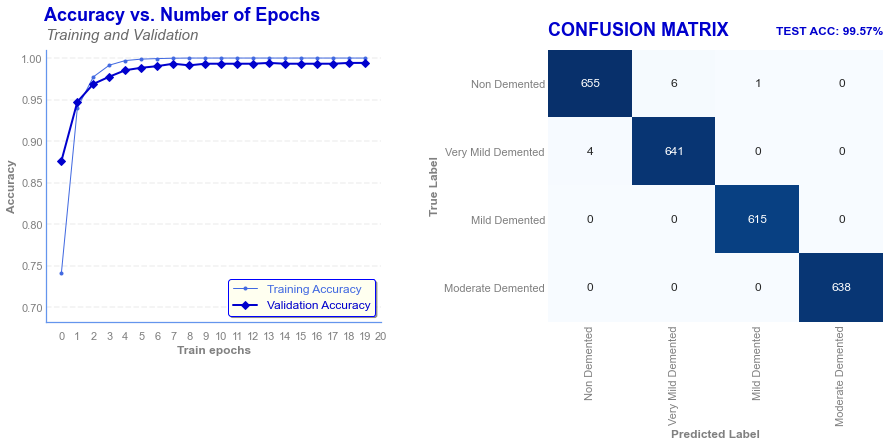

Experiment_6

Hidden Layer 1 size: 256
Hidden Layer 2 size: 128
Activation function: relu
Optimizer: Adam
Learning Rate: 0.0001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 49152)               0         
                                                                 
 Hidden_1 (Dense)            (64, 256)                 12583168  
                                                                 
 Hidden_2 (Dense)            (64, 128)                 32896     
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 12,616,580
Trainable params: 12,616,580
Non-trainable params: 0
_________________________________________________________________


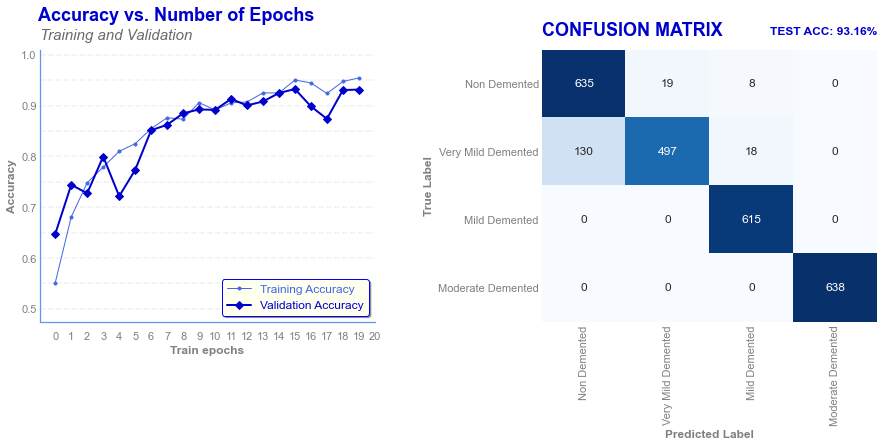

Experiment_6_PCA

Hidden Layer 1 size: 256
Hidden Layer 2 size: 128
Activation function: relu
Optimizer: Adam
Learning Rate: 0.0001
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 225)                 0         
                                                                 
 Hidden_1 (Dense)            (64, 256)                 57856     
                                                                 
 Hidden_2 (Dense)            (64, 128)                 32896     
                                                                 
 Output (Dense)              (64, 4)                   516       
                                                                 
Total params: 91,268
Trainable params: 91,268
Non-trainable params: 0
_________________________________________________________________


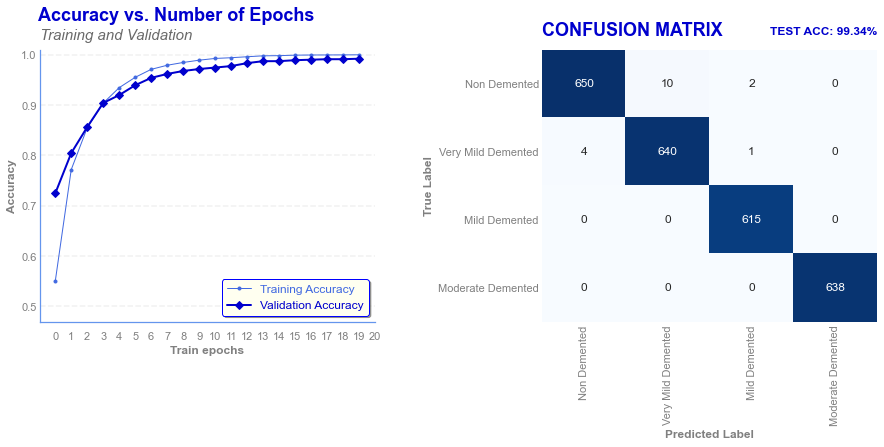

In [28]:
for i in range (1,len(experiments_nndf.index)+1):
    print('Experiment_' + str(i) + '\n')
    accu, param, metrics = train_and_evaluate_nn(X_train, Y_train, X_test, Y_test,
                                        hidden_layer_sizes = experiments_nndf.loc['Experiment_' + str(i), 'HIDDEN SIZES'], 
                                        activation = experiments_nndf.loc['Experiment_' + str(i), 'ACTIVATION'], 
                                        optimizer = experiments_nndf.loc['Experiment_' + str(i), 'OPTIMIZER'], 
                                        learning_rate = experiments_nndf.loc['Experiment_' + str(i), 'LEARNING RATE'], 
                                        num_epochs = experiments_nndf.loc['Experiment_' + str(i), 'EPOCHS'])
    
    experiments_nndf.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_nndf.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    
    
    print('Experiment_' + str(i) + '_PCA\n')
    accu_pca, param_pca, metrics = train_and_evaluate_nn(X_train_pca, Y_train, X_test_pca, Y_test,
                                        hidden_layer_sizes = experiments_nndf.loc['Experiment_' + str(i), 'HIDDEN SIZES'], 
                                        activation = experiments_nndf.loc['Experiment_' + str(i), 'ACTIVATION'], 
                                        optimizer = experiments_nndf.loc['Experiment_' + str(i), 'OPTIMIZER'], 
                                        learning_rate = experiments_nndf.loc['Experiment_' + str(i), 'LEARNING RATE'], 
                                        num_epochs = experiments_nndf.loc['Experiment_' + str(i), 'EPOCHS'])
    
    experiments_nndf.loc['Experiment_' + str(i), '# PARAMETERS (PCA)'] = param_pca
    experiments_nndf.loc['Experiment_' + str(i), 'TEST ACCURACY (PCA)'] = accu_pca
    experiments_nndf.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_nndf.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    experiments_nndf.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_nndf.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_nndf.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]

In [29]:
experiments_nndf

ACTIVATION OPTIMIZER HIDDEN SIZES  LEARNING RATE  EPOCHS  \
Experiment_1       relu      Adam           []         0.0100      21   
Experiment_2       tanh       SGD        [128]         0.0100       5   
Experiment_3       tanh       SGD   [256, 128]         0.0100      20   
Experiment_4       relu       SGD        [128]         0.0001      20   
Experiment_5       relu      Adam        [128]         0.0010      20   
Experiment_6       relu      Adam   [256, 128]         0.0001      20   

              # PARAMETERS  TEST ACCURACY  # PARAMETERS (PCA)  \
Experiment_1        196612       0.601172                 904   
Experiment_2       6292100       0.616016               29444   
Experiment_3      12616580       0.836719               91268   
Experiment_4       6292100       0.694531               29444   
Experiment_5       6292100       0.774609               29444   
Experiment_6      12616580       0.931641               91268   

              TEST ACCURACY (PCA) TRAIN ACCURACY VAL ACCURACY PRECISON  \
Experiment_1             0.798047         0.8086       0.8262   0.7982   
Experiment_2             0.793359         0.7804       0.7617   0.7913   
Experiment_3             0.968359         0.8304       0.8154   0.9689   
Experiment_4             0.551172         0.3016       0.3320   0.5318   
Experiment_5             0.995703         0.9914       0.9775   0.9958   
Experiment_6             0.993359         0.9040       0.9043   0.9934   

              RECALL F1 SCORE  
Experiment_1  0.8001   0.7985  
Experiment_2  0.7962   0.7899  
Experiment_3  0.9691   0.9688  
Experiment_4  0.5517   0.5397  
Experiment_5  0.9958   0.9958  
Experiment_6  0.9935   0.9935

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">CNN</div>

In [30]:
X_train_pca_sq = X_train_pca.reshape(X_train_pca.shape[0], int(np.sqrt(X_train_pca.shape[1])), int(np.sqrt(X_train_pca.shape[1])), 1)
X_test_pca_sq = X_test_pca.reshape(X_test_pca.shape[0], int(np.sqrt(X_test_pca.shape[1])), int(np.sqrt(X_test_pca.shape[1])), 1)

In [31]:
def build_cnn_model(input_shape,
                    kern_sz = (5,5), 
                    stri_sz = (1,1), 
                    pool_sz = (2,2),
                    lear_rt = 0.001,
                    optimiz = 'Adam'):
    
    tf.keras.backend.clear_session()
    np.random.seed(5678)
    tf.random.set_seed(5678)
    random.seed(5678)
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = kern_sz,
        strides = stri_sz,
        padding = 'same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation = 'relu'))


    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size = pool_sz,
        name = 'pool_1'))


    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters = 64,
        kernel_size = kern_sz,
        strides = stri_sz,
        padding = 'same',
        name = 'conv_2',
        activation = 'relu'))

    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size = pool_sz, 
        name='pool_2'))


    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
        units = 1024,
        name = 'fc_1', 
        activation = 'relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
        rate = 0.5))

    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units = 4,
        name = 'fc_2',
        activation = None))


    # build model and print summary
    model.build(input_shape = input_shape)
    
    if optimiz == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate = lear_rt)
    elif optimiz == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate = lear_rt)
    else:
        opt = optimiz
        print('Optimizer: ' + optimizer)
        
    model.compile(optimizer = opt,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics = ['accuracy'])
    
    return model

In [32]:
def build_n_run_cnn_model(x_train,
                          y_train,
                          x_test,
                          y_test,
                          kern_sz = (5,5), 
                          stri_sz = (1,1), 
                          pool_sz = (2,2),
                          lear_rt = 0.001,
                          optimiz = 'Adam', 
                          num_epochs = 20,
                          verb=False, 
                          graphing = True):

    model = build_cnn_model(x_train.shape, kern_sz, stri_sz, pool_sz, lear_rt, optimiz) 

    model.summary()
    
    history = model.fit(x_train, 
                        y_train,
                        epochs = num_epochs, 
                        validation_split=0.1,
                        verbose = verb)
    
    hist = history.history
    if (graphing):
        x_arr = np.arange(len(hist['loss'])) + 1
        
        ## Plot mean CV accuracies for Tree Depth
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss', 
             color = 'salmon', lw = 1)
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss', 
                 color = 'firebrick', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Loss vs. Number of Epochs", weight='bold', color = 'firebrick', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 1, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['salmon','firebrick'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Loss', color = 'gray', weight = 'bold')
        ax.set_ylim(bottom = -0.01)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = "Training Accuracy", 
             color = 'royalblue', lw = 1)
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = "Validation Accuracy", 
                 color = 'mediumblue', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Accuracy vs. Number of Epochs", weight='bold', color = 'mediumblue', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 4, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['royalblue','mediumblue'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
        ax.set_ylim(top = 1.01)
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

    test_accuracy = model.evaluate(x_test, y_test, verbose=0, return_dict=True)['accuracy']
    
    metrics = compute_model_performance_metrics(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')
    
    num_params = model.count_params()
    
    return [test_accuracy, num_params, metrics]

In [33]:
# Generating a Dataframe with all the experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
kern_sz = [(5,5)] + [(3,3)] + [(5,5)] * 4
strides = [(1,1)] * 2 + [(2,2)] + [(1,1)] * 3
pool_sz = [(2,2)] * 3 + [(3,3)] + [(2,2)] * 2
lear_rt = [0.001] * 4 + [0.01] + [0.001]
optimiz = ['Adam'] * 5 + ['SGD']

experiments_cnn_df = pd.DataFrame({'kernel size': kern_sz, 
                               'strides': strides, 
                               'pool size': pool_sz, 
                               'learning rate': lear_rt, 
                               'optimizer': optimiz},
                             index = exp_ind)

In [34]:
experiments_cnn_df 

kernel size strides pool size  learning rate optimizer
Experiment_1      (5, 5)  (1, 1)    (2, 2)          0.001      Adam
Experiment_2      (3, 3)  (1, 1)    (2, 2)          0.001      Adam
Experiment_3      (5, 5)  (2, 2)    (2, 2)          0.001      Adam
Experiment_4      (5, 5)  (1, 1)    (3, 3)          0.001      Adam
Experiment_5      (5, 5)  (1, 1)    (2, 2)          0.010      Adam
Experiment_6      (5, 5)  (1, 1)    (2, 2)          0.001       SGD

Experiment_1

kernel size      (5, 5)
strides          (1, 1)
pool size        (2, 2)
learning rate     0.001
optimizer          Adam
Name: Experiment_1, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (10240, 15, 15, 32)       832       
                                                                 
 pool_1 (MaxPooling2D)       (10240, 7, 7, 32)         0         
                                                                 
 conv_2 (Conv2D)             (10240, 7, 7, 64)         51264     
                                                                 
 pool_2 (MaxPooling2D)       (10240, 3, 3, 64)         0         
                                                                 
 flatten (Flatten)           (10240, 576)              0         
                                                                 
 fc_1 (Dense)     

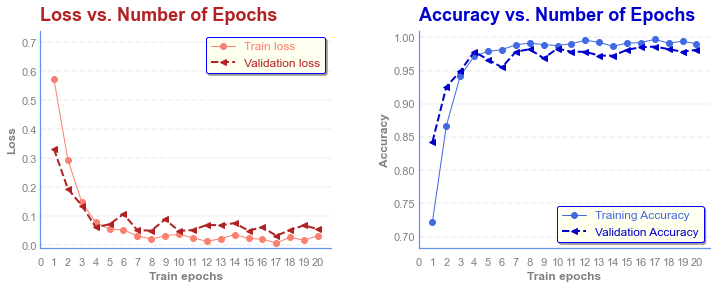

Test Accuracy: 0.9836


Experiment_2

kernel size      (3, 3)
strides          (1, 1)
pool size        (2, 2)
learning rate     0.001
optimizer          Adam
Name: Experiment_2, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (10240, 15, 15, 32)       320       
                                                                 
 pool_1 (MaxPooling2D)       (10240, 7, 7, 32)         0         
                                                                 
 conv_2 (Conv2D)             (10240, 7, 7, 64)         18496     
                                                                 
 pool_2 (MaxPooling2D)       (10240, 3, 3, 64)         0         
                                                                 
 flatten (Flatten)           (10240, 576)              0         
                                                            

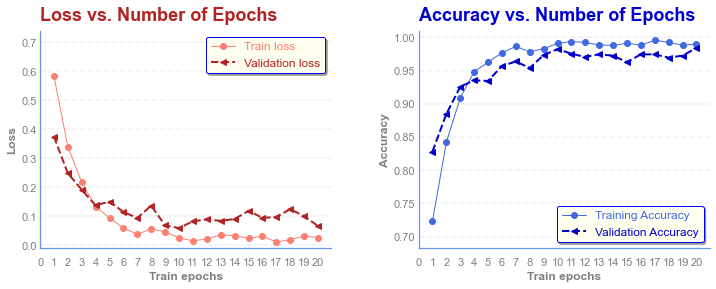

Test Accuracy: 0.9773


Experiment_3

kernel size      (5, 5)
strides          (2, 2)
pool size        (2, 2)
learning rate     0.001
optimizer          Adam
Name: Experiment_3, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (10240, 8, 8, 32)         832       
                                                                 
 pool_1 (MaxPooling2D)       (10240, 4, 4, 32)         0         
                                                                 
 conv_2 (Conv2D)             (10240, 2, 2, 64)         51264     
                                                                 
 pool_2 (MaxPooling2D)       (10240, 1, 1, 64)         0         
                                                                 
 flatten (Flatten)           (10240, 64)               0         
                                                            

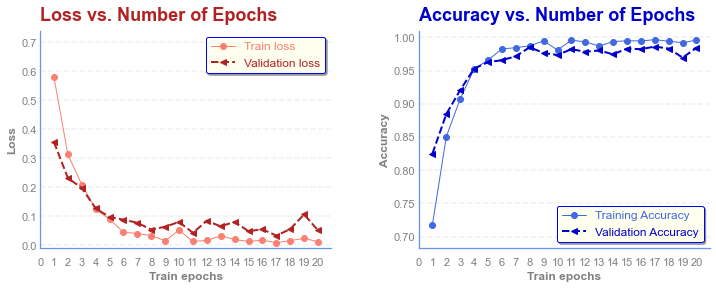

Test Accuracy: 0.9828


Experiment_4

kernel size      (5, 5)
strides          (1, 1)
pool size        (3, 3)
learning rate     0.001
optimizer          Adam
Name: Experiment_4, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (10240, 15, 15, 32)       832       
                                                                 
 pool_1 (MaxPooling2D)       (10240, 5, 5, 32)         0         
                                                                 
 conv_2 (Conv2D)             (10240, 5, 5, 64)         51264     
                                                                 
 pool_2 (MaxPooling2D)       (10240, 1, 1, 64)         0         
                                                                 
 flatten (Flatten)           (10240, 64)               0         
                                                            

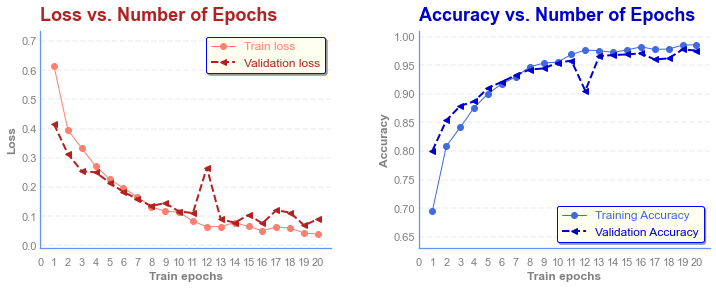

Test Accuracy: 0.9723


Experiment_5

kernel size      (5, 5)
strides          (1, 1)
pool size        (2, 2)
learning rate      0.01
optimizer          Adam
Name: Experiment_5, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (10240, 15, 15, 32)       832       
                                                                 
 pool_1 (MaxPooling2D)       (10240, 7, 7, 32)         0         
                                                                 
 conv_2 (Conv2D)             (10240, 7, 7, 64)         51264     
                                                                 
 pool_2 (MaxPooling2D)       (10240, 3, 3, 64)         0         
                                                                 
 flatten (Flatten)           (10240, 576)              0         
                                                            

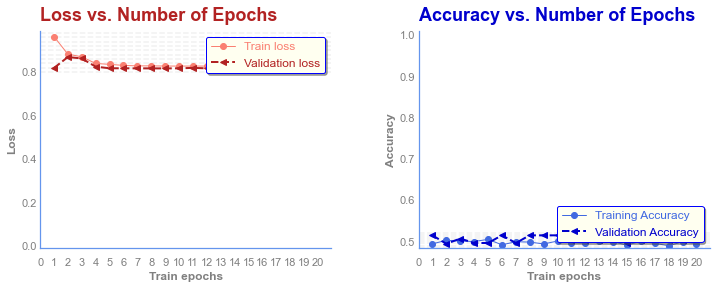

Test Accuracy: 0.4895


Experiment_6

kernel size      (5, 5)
strides          (1, 1)
pool size        (2, 2)
learning rate     0.001
optimizer           SGD
Name: Experiment_6, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (10240, 15, 15, 32)       832       
                                                                 
 pool_1 (MaxPooling2D)       (10240, 7, 7, 32)         0         
                                                                 
 conv_2 (Conv2D)             (10240, 7, 7, 64)         51264     
                                                                 
 pool_2 (MaxPooling2D)       (10240, 3, 3, 64)         0         
                                                                 
 flatten (Flatten)           (10240, 576)              0         
                                                            

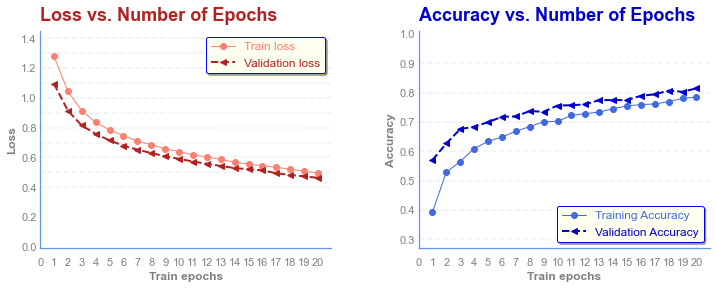

Test Accuracy: 0.7824




In [35]:
for i in range (1,len(experiments_cnn_df.index)+1):
    print('Experiment_' + str(i) + '\n')
    print(experiments_cnn_df.loc['Experiment_'+ str(i),'kernel size':'optimizer'], '\n')
    
    accu , param, metrics = build_n_run_cnn_model(X_train_pca_sq, Y_train, X_test_pca_sq, Y_test,
                                 kern_sz = experiments_cnn_df.loc['Experiment_' + str(i), 'kernel size'], 
                                 stri_sz = experiments_cnn_df.loc['Experiment_' + str(i), 'strides'],
                                 pool_sz = experiments_cnn_df.loc['Experiment_' + str(i), 'pool size'],
                                 lear_rt = experiments_cnn_df.loc['Experiment_' + str(i), 'learning rate'],
                                 optimiz = experiments_cnn_df.loc['Experiment_' + str(i), 'optimizer'])

    experiments_cnn_df.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_cnn_df.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    experiments_cnn_df.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_cnn_df.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    #experiments_cnn_df.loc['Experiment_' + str(i), 'ACCURACY'] = metrics["accuracy"]
    experiments_cnn_df.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_cnn_df.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_cnn_df.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]
    
    print('Test Accuracy: %1.4f' % accu + '\n\n')

In [36]:
experiments_cnn_df

kernel size strides pool size  learning rate optimizer  \
Experiment_1      (5, 5)  (1, 1)    (2, 2)          0.001      Adam   
Experiment_2      (3, 3)  (1, 1)    (2, 2)          0.001      Adam   
Experiment_3      (5, 5)  (2, 2)    (2, 2)          0.001      Adam   
Experiment_4      (5, 5)  (1, 1)    (3, 3)          0.001      Adam   
Experiment_5      (5, 5)  (1, 1)    (2, 2)          0.010      Adam   
Experiment_6      (5, 5)  (1, 1)    (2, 2)          0.001       SGD   

              # PARAMETERS  TEST ACCURACY TRAIN ACCURACY VAL ACCURACY  \
Experiment_1      647044.0       0.983594         0.9718       0.9785   
Experiment_2      613764.0       0.977344         0.9485       0.9355   
Experiment_3      122756.0       0.982813         0.9526       0.9531   
Experiment_4      122756.0       0.972266         0.8760       0.8867   
Experiment_5      647044.0       0.489453         0.4997       0.4961   
Experiment_6      647044.0       0.782422         0.6095       0.6836   

             PRECISON  RECALL F1 SCORE  
Experiment_1   0.9839  0.9837   0.9838  
Experiment_2   0.9775  0.9778   0.9776  
Experiment_3   0.9832  0.9832   0.9831  
Experiment_4   0.9727  0.9728   0.9727  
Experiment_5   0.3293  0.5000   0.3709  
Experiment_6   0.7823  0.7849   0.7827

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;"> CNN + LSTM</div>

In [37]:
print('Shape before X_train_pca_sq', X_train_pca_sq.shape)
print('Shape Y_train', Y_train.shape)

#reshape to time-series sequence of size 10
X_train_seq = np.reshape(X_train_pca_sq, (int(X_train_pca_sq.shape[0]/10), 10, X_train_pca_sq.shape[1], X_train_pca_sq.shape[2], X_train_pca_sq.shape[3]))
Y_train_seq = np.reshape(Y_train, (int(Y_train.shape[0]/10), 10))

X_test_seq = np.reshape(X_test_pca_sq, (int(X_test_pca_sq.shape[0]/10), 10, X_test_pca_sq.shape[1], X_test_pca_sq.shape[2], X_test_pca_sq.shape[3]))
Y_test_seq = np.reshape(Y_test, (int(Y_test.shape[0]/10), 10))

print('Shape X_train_seq', X_train_seq.shape)
print('Shape Y_train_seq', Y_train_seq.shape)

print('Shape X_test_seq', X_test_seq.shape)
print('Shape Y_test_seq', Y_test_seq.shape)

Shape before X_train_pca_sq (10240, 15, 15, 1)
Shape Y_train (10240,)
Shape X_train_seq (1024, 10, 15, 15, 1)
Shape Y_train_seq (1024, 10)
Shape X_test_seq (256, 10, 15, 15, 1)
Shape Y_test_seq (256, 10)


In [38]:
def build_cnnlstm_model(input_shape,
                         kern_sz = (5,5), 
                         stri_sz = (1,1), 
                         pool_sz = (2,2),
                         lear_rt = 0.001,
                         optimiz = 'Adam'):
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = kern_sz,
        strides = stri_sz,
        padding = 'same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation = 'relu')))

    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(
        pool_size = pool_sz,
        name = 'pool_1')))


    # add second convolutional layer
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(
        filters = 64,
        kernel_size = kern_sz,
        strides = stri_sz,
        padding = 'same',
        name = 'conv_2',
        activation = 'relu')))

    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool2D(
        pool_size = pool_sz, 
        name='pool_2')))


    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
        units = 1024,
        name = 'fc_1', 
        activation = 'relu')))

    # add dropout layer
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(rate = 0.5)))

    #Add LSTM layers
    model.add(tf.keras.layers.LSTM(1024, return_sequences=True))
    model.add(tf.keras.layers.Dense(units=4, name='fc_2', activation=None))

    model.build(input_shape=input_shape)
    
    if optimiz == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate = lear_rt)
    elif optimiz == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate = lear_rt)
    else:
        opt = optimiz
        print('Optimizer: ' + optimizer)
    
    model.compile(optimizer=opt, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy'])
    
    return model

In [39]:
def buildrun_cnnlstm_model(x_train,
                          y_train,
                          x_test,
                          y_test,
                          kern_sz = (5,5), 
                          stri_sz = (1,1), 
                          pool_sz = (2,2),
                          lear_rt = 0.001,
                          optimiz = 'Adam', 
                          num_epochs = 20,
                          verb=False, 
                          graphing = True):

    model = build_cnnlstm_model(x_train.shape, kern_sz, stri_sz, pool_sz, lear_rt, optimiz) 

    model.summary()
    
    history = model.fit(x_train, 
                        y_train,
                        epochs = num_epochs, 
                        validation_split=0.1,
                        verbose = verb)
    
    hist = history.history
    if (graphing):
        x_arr = np.arange(len(hist['loss'])) + 1
        
        ## Plot mean CV accuracies for Tree Depth
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss', 
             color = 'salmon', lw = 1)
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss', 
                 color = 'firebrick', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Loss vs. Number of Epochs", weight='bold', color = 'firebrick', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 1, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['salmon','firebrick'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Loss', color = 'gray', weight = 'bold')
        ax.set_ylim(bottom = -0.01)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = "Training Accuracy", 
             color = 'royalblue', lw = 1)
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = "Validation Accuracy", 
                 color = 'mediumblue', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Accuracy vs. Number of Epochs", weight='bold', color = 'mediumblue', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 4, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['royalblue','mediumblue'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
        ax.set_ylim(top = 1.01)
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

    test_accuracy = model.evaluate(x_test, y_test, verbose=0, return_dict=True)['accuracy']
    
    metrics = compute_model_performance_metrics_cnn_lstm(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')
    
    num_params = model.count_params()
    
    return [test_accuracy, num_params, metrics]

In [40]:
# Generating a Dataframe with all the experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
kern_sz = [(5,5)] + [(3,3)] + [(5,5)] * 4
strides = [(1,1)] * 2 + [(2,2)] + [(1,1)] * 3
pool_sz = [(2,2)] * 3 + [(3,3)] + [(2,2)] * 2
lear_rt = [0.001] * 4 + [0.01] + [0.001]
optimiz = ['Adam'] * 5 + ['SGD']

experiments_cnnlstm_df = pd.DataFrame({'kernel size': kern_sz, 
                                       'strides': strides, 
                                       'pool size': pool_sz, 
                                       'learning rate': lear_rt, 
                                       'optimizer': optimiz},
                                     index = exp_ind)

Experiment_1

kernel size      (5, 5)
strides          (1, 1)
pool size        (2, 2)
learning rate     0.001
optimizer          Adam
Name: Experiment_1, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1024, 10, 15, 15, 32)   832       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1024, 10, 7, 7, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1024, 10, 7, 7, 64)     51264     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1024, 10, 3, 3, 64)     0         
 tributed)        

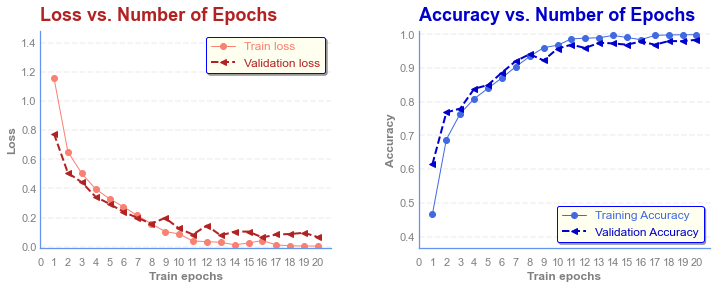

Test Accuracy: 0.9820


Experiment_2

kernel size      (3, 3)
strides          (1, 1)
pool size        (2, 2)
learning rate     0.001
optimizer          Adam
Name: Experiment_2, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1024, 10, 15, 15, 32)   320       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1024, 10, 7, 7, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1024, 10, 7, 7, 64)     18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1024, 10, 3, 3, 64)     0    

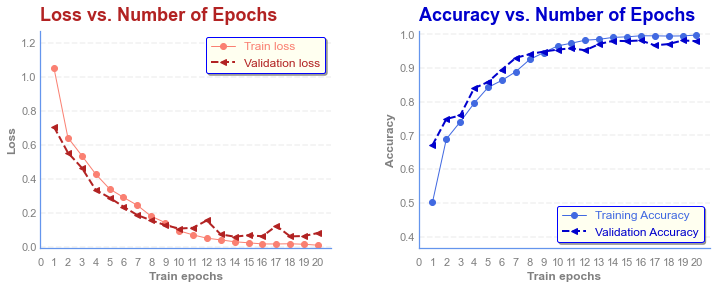

Test Accuracy: 0.9734


Experiment_3

kernel size      (5, 5)
strides          (2, 2)
pool size        (2, 2)
learning rate     0.001
optimizer          Adam
Name: Experiment_3, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1024, 10, 8, 8, 32)     832       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1024, 10, 4, 4, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1024, 10, 2, 2, 64)     51264     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1024, 10, 1, 1, 64)     0    

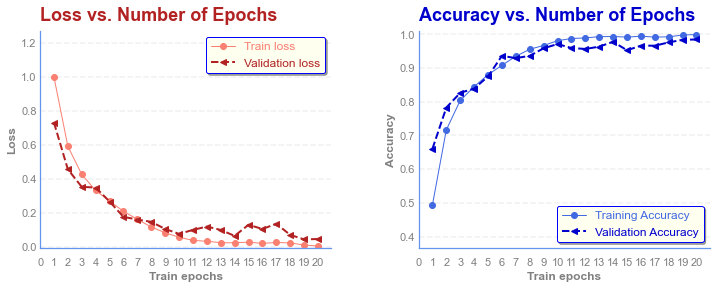

Test Accuracy: 0.9812


Experiment_4

kernel size      (5, 5)
strides          (1, 1)
pool size        (3, 3)
learning rate     0.001
optimizer          Adam
Name: Experiment_4, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1024, 10, 15, 15, 32)   832       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1024, 10, 5, 5, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1024, 10, 5, 5, 64)     51264     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1024, 10, 1, 1, 64)     0    

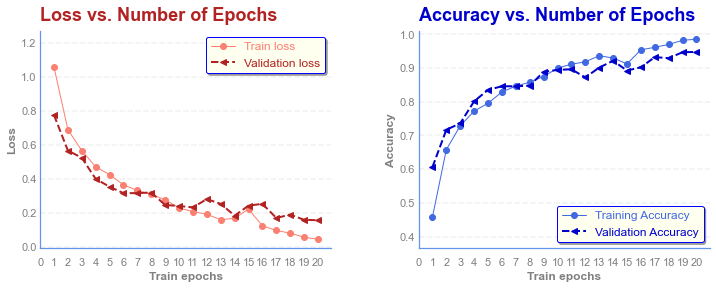

Test Accuracy: 0.9543


Experiment_5

kernel size      (5, 5)
strides          (1, 1)
pool size        (2, 2)
learning rate      0.01
optimizer          Adam
Name: Experiment_5, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1024, 10, 15, 15, 32)   832       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1024, 10, 7, 7, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1024, 10, 7, 7, 64)     51264     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1024, 10, 3, 3, 64)     0    

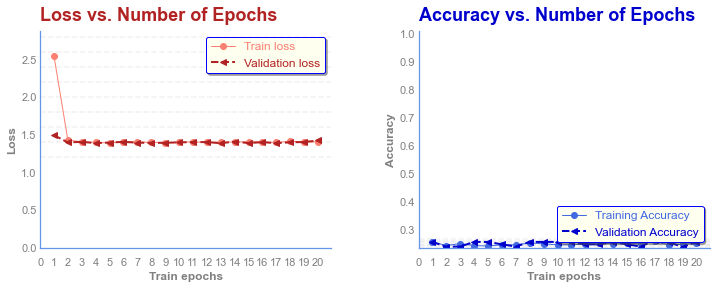

Test Accuracy: 0.2402


Experiment_6

kernel size      (5, 5)
strides          (1, 1)
pool size        (2, 2)
learning rate     0.001
optimizer           SGD
Name: Experiment_6, dtype: object 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (1024, 10, 15, 15, 32)   832       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (1024, 10, 7, 7, 32)     0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (1024, 10, 7, 7, 64)     51264     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (1024, 10, 3, 3, 64)     0    

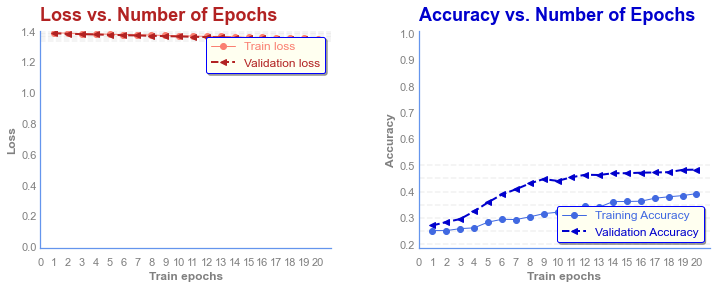

Test Accuracy: 0.4563




In [41]:
for i in range (1,len(experiments_cnnlstm_df.index)+1):
    print('Experiment_' + str(i) + '\n')
    print(experiments_cnnlstm_df.loc['Experiment_'+ str(i),'kernel size':'optimizer'], '\n')
    
    accu , param, metrics = buildrun_cnnlstm_model(X_train_seq, Y_train_seq, X_test_seq, Y_test_seq,
                                 kern_sz = experiments_cnnlstm_df.loc['Experiment_' + str(i), 'kernel size'], 
                                 stri_sz = experiments_cnnlstm_df.loc['Experiment_' + str(i), 'strides'],
                                 pool_sz = experiments_cnnlstm_df.loc['Experiment_' + str(i), 'pool size'],
                                 lear_rt = experiments_cnnlstm_df.loc['Experiment_' + str(i), 'learning rate'],
                                 optimiz = experiments_cnnlstm_df.loc['Experiment_' + str(i), 'optimizer'])

    experiments_cnnlstm_df.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_cnnlstm_df.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    experiments_cnnlstm_df.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_cnnlstm_df.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    #experiments_cnnlstm_df.loc['Experiment_' + str(i), 'ACCURACY'] = metrics["accuracy"]
    experiments_cnnlstm_df.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_cnnlstm_df.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_cnnlstm_df.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]
    
    print('Test Accuracy: %1.4f' % accu + '\n\n')

In [42]:
experiments_cnnlstm_df

kernel size strides pool size  learning rate optimizer  \
Experiment_1      (5, 5)  (1, 1)    (2, 2)          0.001      Adam   
Experiment_2      (3, 3)  (1, 1)    (2, 2)          0.001      Adam   
Experiment_3      (5, 5)  (2, 2)    (2, 2)          0.001      Adam   
Experiment_4      (5, 5)  (1, 1)    (3, 3)          0.001      Adam   
Experiment_5      (5, 5)  (1, 1)    (2, 2)          0.010      Adam   
Experiment_6      (5, 5)  (1, 1)    (2, 2)          0.001       SGD   

              # PARAMETERS  TEST ACCURACY TRAIN ACCURACY VAL ACCURACY  \
Experiment_1     9039748.0       0.982031         0.8081       0.8379   
Experiment_2     9006468.0       0.973437         0.7952       0.8398   
Experiment_3     8515460.0       0.981250         0.8445       0.8388   
Experiment_4     8515460.0       0.954297         0.7720       0.8010   
Experiment_5     9039748.0       0.240234         0.2432       0.2563   
Experiment_6     9039748.0       0.456250         0.2625       0.3252   

             PRECISON  RECALL F1 SCORE  
Experiment_1   0.9823  0.9824   0.9823  
Experiment_2   0.9740  0.9740   0.9738  
Experiment_3   0.9814  0.9817   0.9815  
Experiment_4   0.9546  0.9553   0.9547  
Experiment_5   0.0601  0.2500   0.0969  
Experiment_6   0.4364  0.4631   0.3819

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">RNN</div>

In [43]:
def build_rnn_model(n_classes,
                    activation= 'relu',
                    optimizer= 'Adam',
                    learning_rate=0.01):
    
    print('Activation function: ' + activation)
    print('Optimizer: ' + optimizer)
    print('Learning Rate: ' + str(learning_rate))
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(None,15)))

    model.add(
        tf.keras.layers.SimpleRNN(225, return_sequences = True, activation = activation)
    )


    model.add(
        tf.keras.layers.SimpleRNN(225, activation = activation)
    )

    model.add(tf.keras.layers.Dense(n_classes))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        opt = optimiz
        print('Optimizer: ' + optimizer)

    model.compile(optimizer = opt,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics = ['accuracy'])

    return model

In [44]:
def build_n_run_rnn_model(x_train,
                          y_train,
                          x_test,
                          y_test,
                          activ= 'relu',
                          lear_rt = 0.001,
                          optimiz = 'Adam', 
                          num_epochs = 10,
                          verb = False, 
                          graphing = True):
    
    print('Number of Epochs: ' + str(num_epochs))
    
    model = build_rnn_model(len(label_names), activ, optimiz, lear_rt) 
    history = model.fit(x_train, 
                        y_train,
                        batch_size = 64,
                        epochs = num_epochs, 
                        validation_split=0.1,
                        verbose = verb)
    
    hist = history.history
    if (graphing):
        x_arr = np.arange(len(hist['loss'])) + 1
        
        ## Plot mean CV accuracies for Tree Depth
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss', 
             color = 'salmon', lw = 1)
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss', 
                 color = 'firebrick', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Loss vs. Number of Epochs", weight='bold', color = 'firebrick', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 1, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['salmon','firebrick'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Loss', color = 'gray', weight = 'bold')
        ax.set_ylim(bottom = -0.01)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = "Training Accuracy", 
             color = 'royalblue', lw = 1)
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = "Validation Accuracy", 
                 color = 'mediumblue', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Accuracy vs. Number of Epochs", weight='bold', color = 'mediumblue', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 4, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['royalblue','mediumblue'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
        ax.set_ylim(top = 1.01)
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

    test_accuracy = model.evaluate(x_test, y_test, verbose=verb, return_dict=True)['accuracy']
    
    metrics = compute_model_performance_metrics(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')
    
    num_params = model.count_params()
    
    return [test_accuracy, num_params, metrics]

In [45]:
# Generating a Dataframe with all the experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
activ = ['relu'] * 2 + ['tanh'] * 2 +  ['relu'] * 2
lear_rt = ([0.01] + [0.001]) * 3
optimiz = ['Adam'] *4 + ['SGD'] * 2

experiments_rnn_df = pd.DataFrame({'activation': activ, 
                                   'learning rate': lear_rt, 
                                   'optimizer': optimiz},
                             index = exp_ind)

Experiment_1

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.01


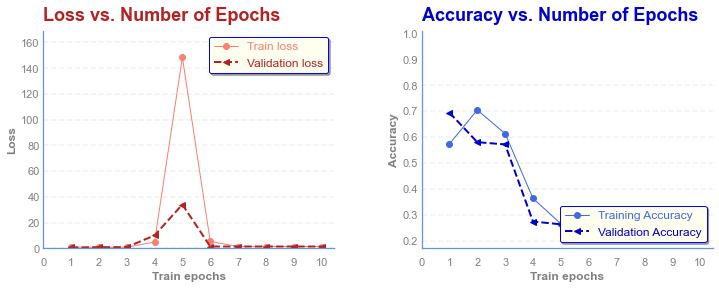

Test Accuracy: 0.2492


Experiment_2

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.001


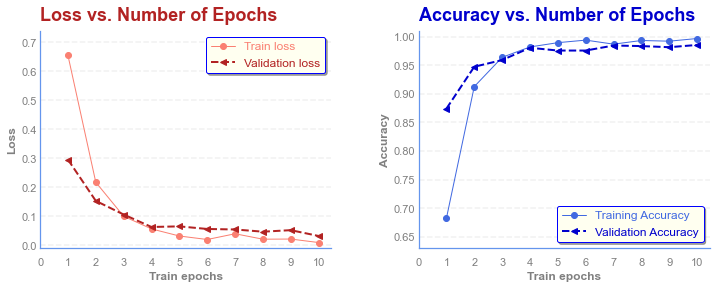

Test Accuracy: 0.9852


Experiment_3

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.01


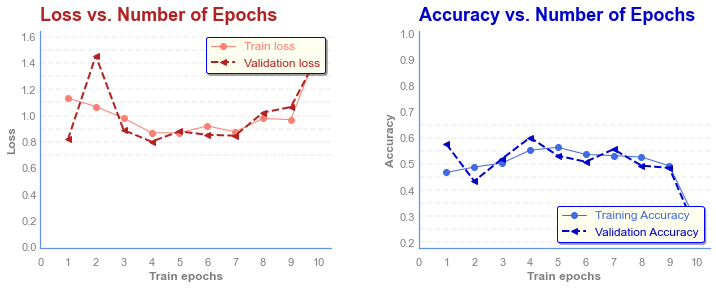

Test Accuracy: 0.2547


Experiment_4

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.001


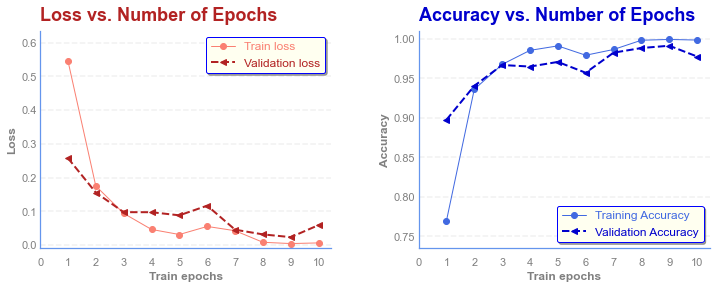

Test Accuracy: 0.9730


Experiment_5

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.01


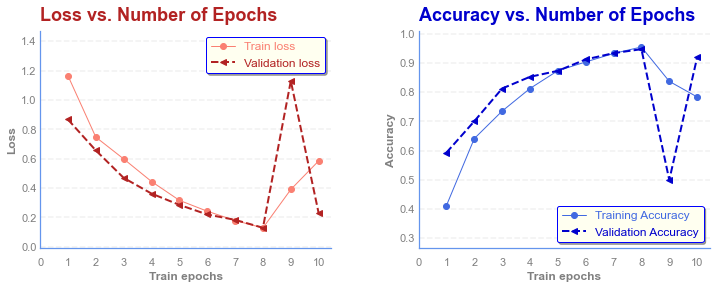

Test Accuracy: 0.9109


Experiment_6

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.001


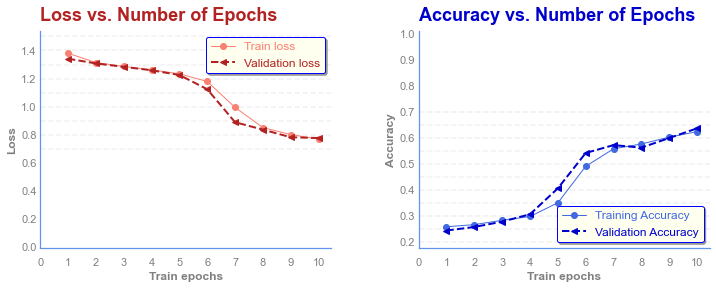

Test Accuracy: 0.6039




In [46]:
for i in range (1,len(experiments_rnn_df.index)+1):
    print('Experiment_' + str(i) + '\n')
    
    accu , param, metrics = build_n_run_rnn_model(X_train_pca_sq, Y_train, X_test_pca_sq, Y_test,
                                                  activ= experiments_rnn_df.loc['Experiment_' + str(i), 'activation'],
                                                  lear_rt = experiments_rnn_df.loc['Experiment_' + str(i), 'learning rate'],
                                                  optimiz = experiments_rnn_df.loc['Experiment_' + str(i), 'optimizer'])

    experiments_rnn_df.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_rnn_df.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    experiments_rnn_df.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_rnn_df.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    #experiments_cnn_df.loc['Experiment_' + str(i), 'ACCURACY'] = metrics["accuracy"]
    experiments_rnn_df.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_rnn_df.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_rnn_df.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]
    
    print('Test Accuracy: %1.4f' % accu + '\n\n')

In [47]:
experiments_rnn_df

activation  learning rate optimizer  # PARAMETERS  TEST ACCURACY  \
Experiment_1       relu          0.010      Adam      156604.0       0.249219   
Experiment_2       relu          0.001      Adam      156604.0       0.985156   
Experiment_3       tanh          0.010      Adam      156604.0       0.254687   
Experiment_4       tanh          0.001      Adam      156604.0       0.973047   
Experiment_5       relu          0.010       SGD      156604.0       0.910937   
Experiment_6       relu          0.001       SGD      156604.0       0.603906   

             TRAIN ACCURACY VAL ACCURACY PRECISON  RECALL F1 SCORE  
Experiment_1         0.3628       0.2734   0.0623  0.2500   0.0997  
Experiment_2         0.9819       0.9805   0.9854  0.9855   0.9854  
Experiment_3         0.5532       0.6016   0.3750  0.2486   0.1660  
Experiment_4         0.9854       0.9648   0.9735  0.9737   0.9734  
Experiment_5         0.8125       0.8525   0.9186  0.9132   0.9112  
Experiment_6         0.2972       0.3057   0.6521  0.6095   0.5537

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">GRU</div>

In [48]:
def build_gru_model(n_classes,
                    activation= 'relu',
                    optimizer= 'Adam',
                    learning_rate=0.01):
    
    print('Activation function: ' + activation)
    print('Optimizer: ' + optimizer)
    print('Learning Rate: ' + str(learning_rate))
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(None,15)))

    model.add(
        tf.keras.layers.GRU(225, return_sequences = True, activation = activation)
    )


    model.add(
        tf.keras.layers.GRU(225, activation = activation)
    )

    model.add(tf.keras.layers.Dense(n_classes))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        opt = optimiz
        print('Optimizer: ' + optimizer)

    model.compile(optimizer = opt,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics = ['accuracy'])

    return model

In [49]:
def build_n_run_gru_model(x_train,
                          y_train,
                          x_test,
                          y_test,
                          activ= 'relu',
                          lear_rt = 0.001,
                          optimiz = 'Adam', 
                          num_epochs = 10,
                          verb = False, 
                          graphing = True):
    
    print('Number of Epochs: ' + str(num_epochs))
    
    model = build_gru_model(len(label_names), activ, optimiz, lear_rt) 
    history = model.fit(x_train, 
                        y_train,
                        batch_size = 64,
                        epochs = num_epochs, 
                        validation_split=0.1,
                        verbose = verb)
    
    hist = history.history
    if (graphing):
        x_arr = np.arange(len(hist['loss'])) + 1
        
        ## Plot mean CV accuracies for Tree Depth
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss', 
             color = 'salmon', lw = 1)
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss', 
                 color = 'firebrick', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Loss vs. Number of Epochs", weight='bold', color = 'firebrick', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 1, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['salmon','firebrick'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Loss', color = 'gray', weight = 'bold')
        ax.set_ylim(bottom = -0.01)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = "Training Accuracy", 
             color = 'royalblue', lw = 1)
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = "Validation Accuracy", 
                 color = 'mediumblue', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Accuracy vs. Number of Epochs", weight='bold', color = 'mediumblue', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 4, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['royalblue','mediumblue'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
        ax.set_ylim(top = 1.01)
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

    test_accuracy = model.evaluate(x_test, y_test, verbose=verb, return_dict=True)['accuracy']
    
    metrics = compute_model_performance_metrics(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')
    
    num_params = model.count_params()
    
    return [test_accuracy, num_params, metrics]

In [50]:
# Generating a Dataframe with all the experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
activ = ['relu'] * 2 + ['tanh'] * 2 +  ['relu'] * 2
lear_rt = ([0.01] + [0.001]) * 3
optimiz = ['Adam'] *4 + ['SGD'] * 2

experiments_gru_df = pd.DataFrame({'activation': activ, 
                                   'learning rate': lear_rt, 
                                   'optimizer': optimiz},
                             index = exp_ind)

Experiment_1

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.01


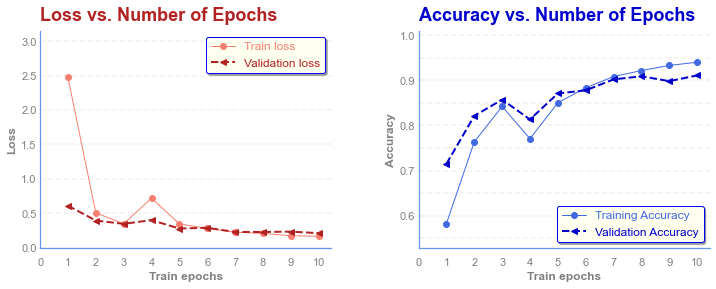

Test Accuracy: 0.8988


Experiment_2

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.001


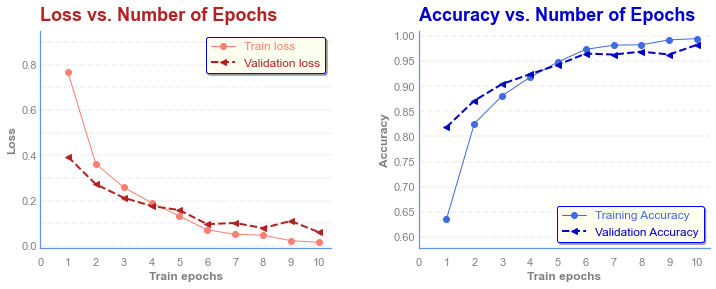

Test Accuracy: 0.9855


Experiment_3

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.01


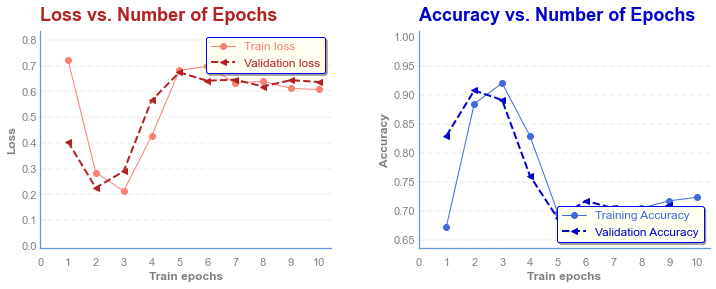

Test Accuracy: 0.7191


Experiment_4

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.001


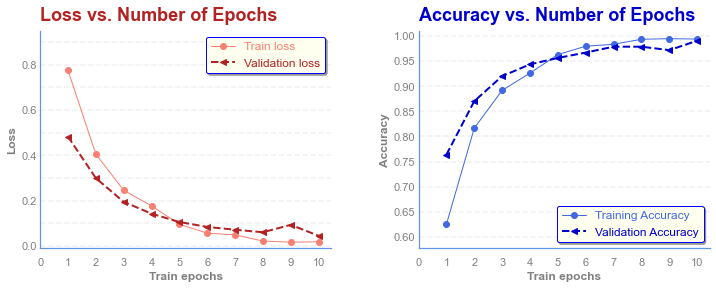

Test Accuracy: 0.9875


Experiment_5

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.01


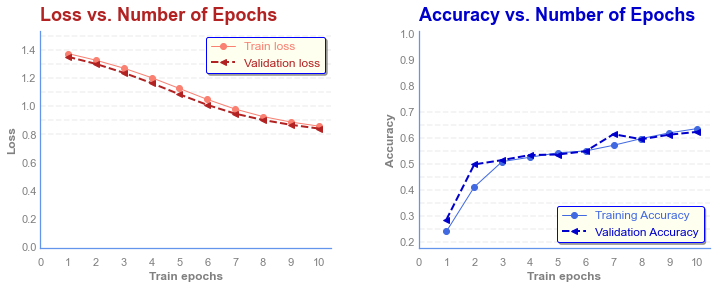

Test Accuracy: 0.6250


Experiment_6

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.001


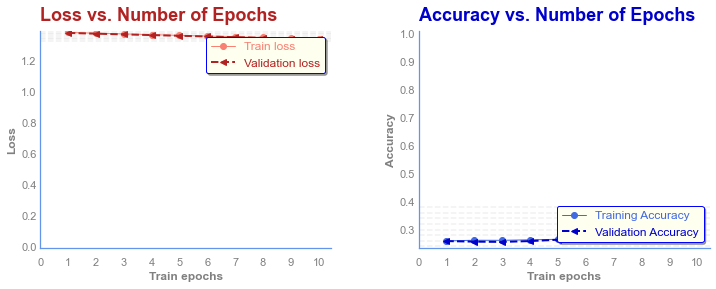

Test Accuracy: 0.3629




In [51]:
for i in range (1,len(experiments_gru_df.index)+1):
    print('Experiment_' + str(i) + '\n')
    
    accu , param, metrics = build_n_run_gru_model(X_train_pca_sq, Y_train, X_test_pca_sq, Y_test,
                                                  activ= experiments_gru_df.loc['Experiment_' + str(i), 'activation'],
                                                  lear_rt = experiments_gru_df.loc['Experiment_' + str(i), 'learning rate'],
                                                  optimiz = experiments_gru_df.loc['Experiment_' + str(i), 'optimizer'])

    experiments_gru_df.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_gru_df.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    experiments_gru_df.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_gru_df.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    #experiments_cnn_df.loc['Experiment_' + str(i), 'ACCURACY'] = metrics["accuracy"]
    experiments_gru_df.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_gru_df.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_gru_df.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]
    
    print('Test Accuracy: %1.4f' % accu + '\n\n')

In [52]:
experiments_gru_df

activation  learning rate optimizer  # PARAMETERS  TEST ACCURACY  \
Experiment_1       relu          0.010      Adam      469354.0       0.898828   
Experiment_2       relu          0.001      Adam      469354.0       0.985547   
Experiment_3       tanh          0.010      Adam      469354.0       0.719141   
Experiment_4       tanh          0.001      Adam      469354.0       0.987500   
Experiment_5       relu          0.010       SGD      469354.0       0.625000   
Experiment_6       relu          0.001       SGD      469354.0       0.362891   

             TRAIN ACCURACY VAL ACCURACY PRECISON  RECALL F1 SCORE  
Experiment_1         0.7707       0.8135   0.9095  0.9005   0.9002  
Experiment_2         0.9176       0.9238   0.9856  0.9859   0.9857  
Experiment_3         0.8286       0.7598   0.7341  0.7186   0.7192  
Experiment_4         0.9260       0.9434   0.9878  0.9877   0.9877  
Experiment_5         0.5246       0.5332   0.6417  0.6307   0.6013  
Experiment_6         0.2633       0.2588   0.4767  0.3640   0.3680

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">RNN + GRU</div>

In [53]:
def build_rnngru_model(n_classes,
                    activation= 'relu',
                    optimizer= 'Adam',
                    learning_rate=0.01):
    
    print('Activation function: ' + activation)
    print('Optimizer: ' + optimizer)
    print('Learning Rate: ' + str(learning_rate))
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(None,15)))

    model.add(
        tf.keras.layers.SimpleRNN(225, return_sequences = True, activation = activation)
    )


    model.add(
        tf.keras.layers.GRU(225, activation = activation)
    )

    model.add(tf.keras.layers.Dense(n_classes))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        opt = optimiz
        print('Optimizer: ' + optimizer)

    model.compile(optimizer = opt,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics = ['accuracy'])

    return model

In [54]:
def build_n_run_rnngru_model(x_train,
                          y_train,
                          x_test,
                          y_test,
                          activ= 'relu',
                          lear_rt = 0.001,
                          optimiz = 'Adam', 
                          num_epochs = 10,
                          verb = False, 
                          graphing = True):
    
    print('Number of Epochs: ' + str(num_epochs))
    
    model = build_rnngru_model(len(label_names), activ, optimiz, lear_rt) 
    history = model.fit(x_train, 
                        y_train,
                        batch_size = 64,
                        epochs = num_epochs, 
                        validation_split=0.1,
                        verbose = verb)
    
    hist = history.history
    if (graphing):
        x_arr = np.arange(len(hist['loss'])) + 1
        
        ## Plot mean CV accuracies for Tree Depth
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss', 
             color = 'salmon', lw = 1)
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss', 
                 color = 'firebrick', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Loss vs. Number of Epochs", weight='bold', color = 'firebrick', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 1, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['salmon','firebrick'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Loss', color = 'gray', weight = 'bold')
        ax.set_ylim(bottom = -0.01)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = "Training Accuracy", 
             color = 'royalblue', lw = 1)
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = "Validation Accuracy", 
                 color = 'mediumblue', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Accuracy vs. Number of Epochs", weight='bold', color = 'mediumblue', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 4, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['royalblue','mediumblue'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
        ax.set_ylim(top = 1.01)
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

    test_accuracy = model.evaluate(x_test, y_test, verbose=verb, return_dict=True)['accuracy']
    
    metrics = compute_model_performance_metrics(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')
    
    num_params = model.count_params()
    
    return [test_accuracy, num_params, metrics]

In [55]:
# Generating a Dataframe with all the experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
activ = ['relu'] * 2 + ['tanh'] * 2 +  ['relu'] * 2
lear_rt = ([0.01] + [0.001]) * 3
optimiz = ['Adam'] *4 + ['SGD'] * 2

experiments_rnngru_df = pd.DataFrame({'activation': activ, 
                                   'learning rate': lear_rt, 
                                   'optimizer': optimiz},
                             index = exp_ind)

Experiment_1

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.01


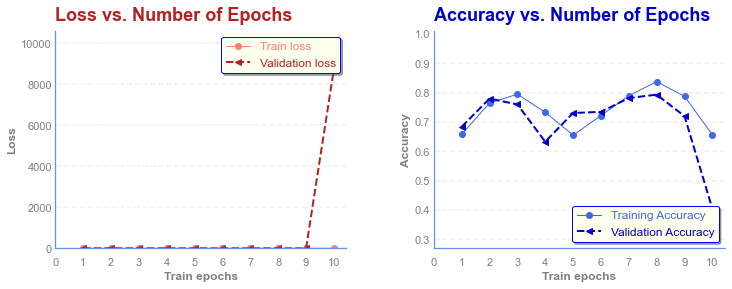

Test Accuracy: 0.3820


Experiment_2

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.001


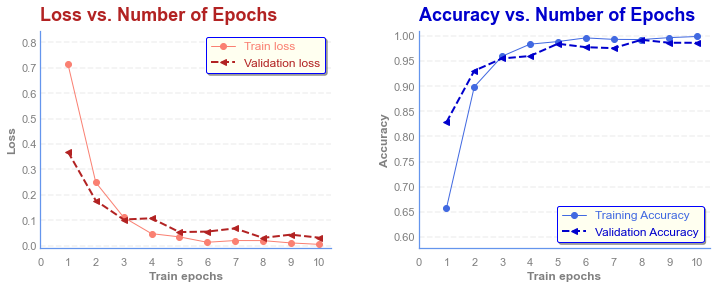

Test Accuracy: 0.9883


Experiment_3

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.01


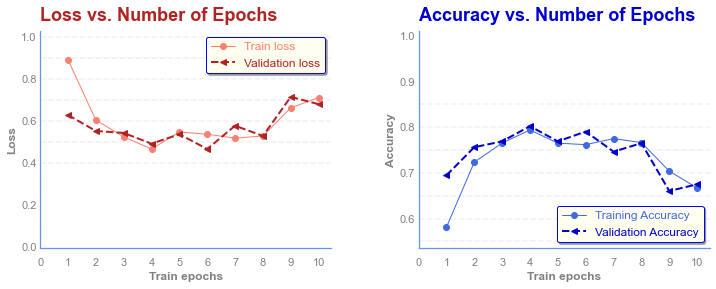

Test Accuracy: 0.6656


Experiment_4

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.001


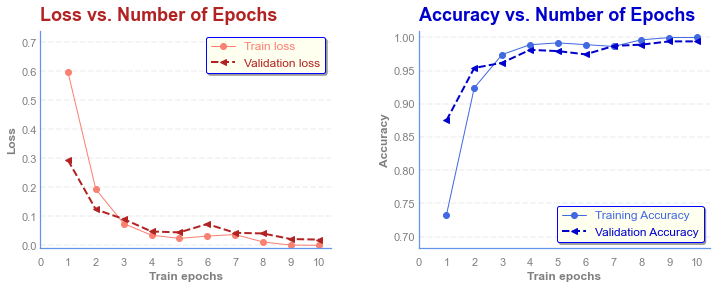

Test Accuracy: 0.9937


Experiment_5

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.01


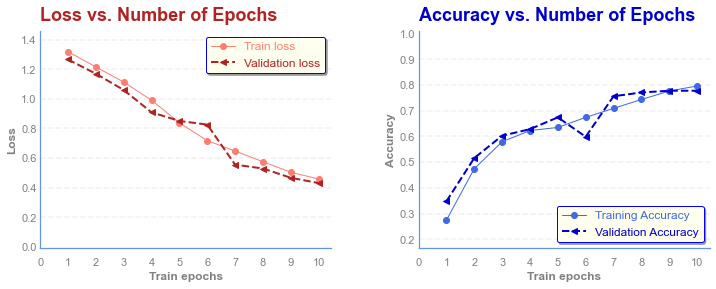

Test Accuracy: 0.7719


Experiment_6

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.001


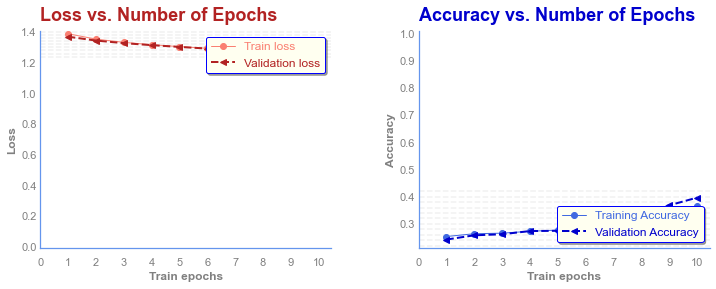

Test Accuracy: 0.3855




In [56]:
for i in range (1,len(experiments_rnngru_df.index)+1):
    print('Experiment_' + str(i) + '\n')
    
    accu , param, metrics = build_n_run_rnngru_model(X_train_pca_sq, Y_train, X_test_pca_sq, Y_test,
                                                  activ= experiments_rnngru_df.loc['Experiment_' + str(i), 'activation'],
                                                  lear_rt = experiments_rnngru_df.loc['Experiment_' + str(i), 'learning rate'],
                                                  optimiz = experiments_rnngru_df.loc['Experiment_' + str(i), 'optimizer'])

    experiments_rnngru_df.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_rnngru_df.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    experiments_rnngru_df.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_rnngru_df.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    #experiments_rnngru_df.loc['Experiment_' + str(i), 'ACCURACY'] = metrics["accuracy"]
    experiments_rnngru_df.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_rnngru_df.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_rnngru_df.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]
    
    print('Test Accuracy: %1.4f' % accu + '\n\n')

In [57]:
experiments_rnngru_df

activation  learning rate optimizer  # PARAMETERS  TEST ACCURACY  \
Experiment_1       relu          0.010      Adam      360229.0       0.382031   
Experiment_2       relu          0.001      Adam      360229.0       0.988281   
Experiment_3       tanh          0.010      Adam      360229.0       0.665625   
Experiment_4       tanh          0.001      Adam      360229.0       0.993750   
Experiment_5       relu          0.010       SGD      360229.0       0.771875   
Experiment_6       relu          0.001       SGD      360229.0       0.385547   

             TRAIN ACCURACY VAL ACCURACY PRECISON  RECALL F1 SCORE  
Experiment_1         0.7327       0.6328   0.5415  0.3889   0.3533  
Experiment_2         0.9835       0.9600   0.9883  0.9886   0.9884  
Experiment_3         0.7935       0.8018   0.6543  0.6659   0.6498  
Experiment_4         0.9891       0.9814   0.9938  0.9939   0.9938  
Experiment_5         0.6226       0.6279   0.8175  0.7780   0.7522  
Experiment_6         0.2727       0.2734   0.4927  0.3882   0.3913

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;"> GRU + LSTM</div>

In [58]:
def build_grulstm_model(n_classes,
                    activation= 'relu',
                    optimizer= 'Adam',
                    learning_rate=0.01):
    
    print('Activation function: ' + activation)
    print('Optimizer: ' + optimizer)
    print('Learning Rate: ' + str(learning_rate))
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(None,15)))

    model.add(
        tf.keras.layers.GRU(225, return_sequences = True, activation = activation)
    )


    model.add(
        tf.keras.layers.LSTM(225, activation = activation)
    )

    model.add(tf.keras.layers.Dense(n_classes))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        opt = optimiz
        print('Optimizer: ' + optimizer)

    model.compile(optimizer = opt,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics = ['accuracy'])

    return model

In [59]:
def build_n_run_grulstm_model(x_train,
                          y_train,
                          x_test,
                          y_test,
                          activ= 'relu',
                          lear_rt = 0.001,
                          optimiz = 'Adam', 
                          num_epochs = 10,
                          verb = False, 
                          graphing = True):
    
    print('Number of Epochs: ' + str(num_epochs))
    
    model = build_grulstm_model(len(label_names), activ, optimiz, lear_rt) 
    history = model.fit(x_train, 
                        y_train,
                        batch_size = 64,
                        epochs = num_epochs, 
                        validation_split=0.1,
                        verbose = verb)
    
    hist = history.history
    if (graphing):
        x_arr = np.arange(len(hist['loss'])) + 1
        
        ## Plot mean CV accuracies for Tree Depth
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss', 
             color = 'salmon', lw = 1)
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss', 
                 color = 'firebrick', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Loss vs. Number of Epochs", weight='bold', color = 'firebrick', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 1, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['salmon','firebrick'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Loss', color = 'gray', weight = 'bold')
        ax.set_ylim(bottom = -0.01)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = "Training Accuracy", 
             color = 'royalblue', lw = 1)
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = "Validation Accuracy", 
                 color = 'mediumblue', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Accuracy vs. Number of Epochs", weight='bold', color = 'mediumblue', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 4, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['royalblue','mediumblue'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
        ax.set_ylim(top = 1.01)
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

    test_accuracy = model.evaluate(x_test, y_test, verbose=verb, return_dict=True)['accuracy']
    
    metrics = compute_model_performance_metrics(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')
    
    num_params = model.count_params()
    
    return [test_accuracy, num_params, metrics]

In [60]:
# Generating a Dataframe with all the experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
activ = ['relu'] * 2 + ['tanh'] * 2 +  ['relu'] * 2
lear_rt = ([0.01] + [0.001]) * 3
optimiz = ['SGD'] * 2 + ['Adam'] *4

experiments_grulstm_df = pd.DataFrame({'activation': activ, 
                                   'learning rate': lear_rt, 
                                   'optimizer': optimiz},
                             index = exp_ind)

Experiment_1

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.01


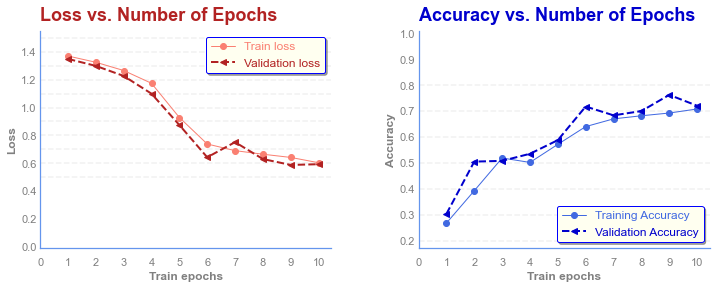

Test Accuracy: 0.7145


Experiment_2

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.001


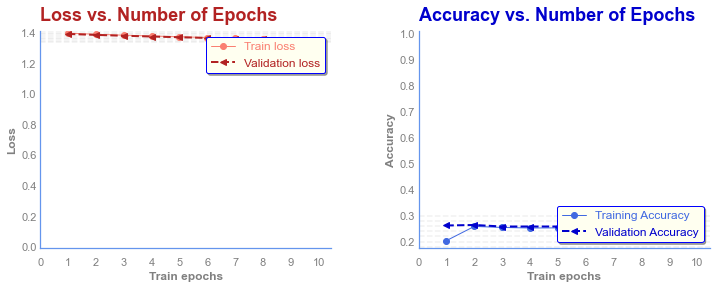

Test Accuracy: 0.2645


Experiment_3

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.01


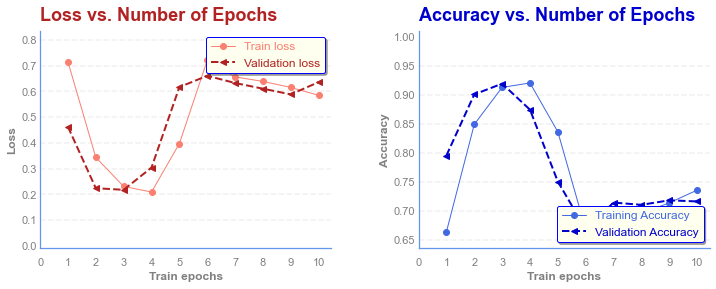

Test Accuracy: 0.7195


Experiment_4

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.001


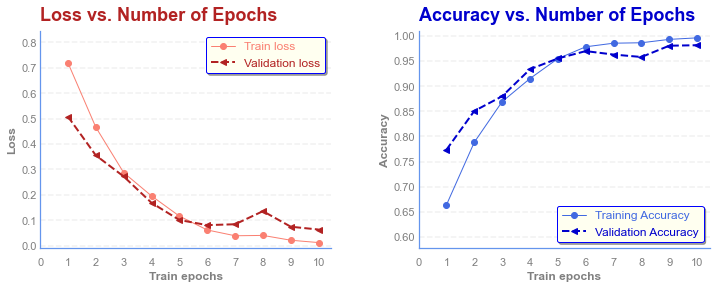

Test Accuracy: 0.9844


Experiment_5

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.01


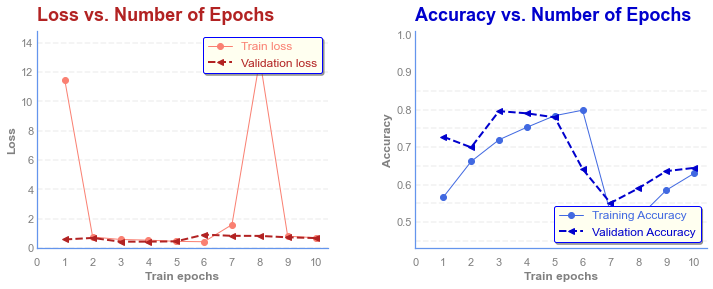

Test Accuracy: 0.6297


Experiment_6

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.001


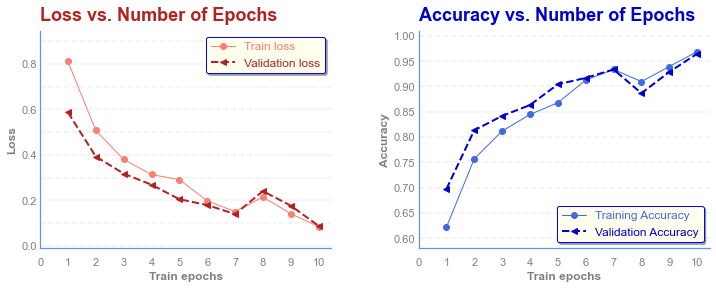

Test Accuracy: 0.9617




In [61]:
for i in range (1,len(experiments_grulstm_df.index)+1):
    print('Experiment_' + str(i) + '\n')
    
    accu , param, metrics = build_n_run_grulstm_model(X_train_pca_sq, Y_train, X_test_pca_sq, Y_test,
                                                  activ= experiments_grulstm_df.loc['Experiment_' + str(i), 'activation'],
                                                  lear_rt = experiments_grulstm_df.loc['Experiment_' + str(i), 'learning rate'],
                                                  optimiz = experiments_grulstm_df.loc['Experiment_' + str(i), 'optimizer'])

    experiments_grulstm_df.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_grulstm_df.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    experiments_grulstm_df.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_grulstm_df.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    #experiments_grulstm_df.loc['Experiment_' + str(i), 'ACCURACY'] = metrics["accuracy"]
    experiments_grulstm_df.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_grulstm_df.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_grulstm_df.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]
    
    print('Test Accuracy: %1.4f' % accu + '\n\n')

In [62]:
experiments_grulstm_df

activation  learning rate optimizer  # PARAMETERS  TEST ACCURACY  \
Experiment_1       relu          0.010       SGD      570154.0       0.714453   
Experiment_2       relu          0.001       SGD      570154.0       0.264453   
Experiment_3       tanh          0.010      Adam      570154.0       0.719531   
Experiment_4       tanh          0.001      Adam      570154.0       0.984375   
Experiment_5       relu          0.010      Adam      570154.0       0.629687   
Experiment_6       relu          0.001      Adam      570154.0       0.961719   

             TRAIN ACCURACY VAL ACCURACY PRECISON  RECALL F1 SCORE  
Experiment_1         0.5017       0.5352   0.7489  0.7196   0.7051  
Experiment_2         0.2521       0.2578   0.3527  0.2740   0.1534  
Experiment_3         0.9201       0.8740   0.7590  0.7213   0.7239  
Experiment_4         0.9151       0.9336   0.9846  0.9848   0.9846  
Experiment_5         0.7528       0.7900   0.6757  0.6304   0.6299  
Experiment_6         0.8446       0.8633   0.9625  0.9624   0.9624

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;"> Bidirectional LSTM + GRU</div>

In [63]:
def build_blstmgru_model(n_classes,
                    activation= 'relu',
                    optimizer= 'Adam',
                    learning_rate=0.01):
    
    print('Activation function: ' + activation)
    print('Optimizer: ' + optimizer)
    print('Learning Rate: ' + str(learning_rate))
    
    tf.keras.backend.clear_session()

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(None,15)))

    model.add(
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(225, return_sequences = True, activation = activation)
        )
    )


    model.add(
        tf.keras.layers.GRU(225, activation = activation)
    )

    model.add(tf.keras.layers.Dense(n_classes))

    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    else:
        opt = optimiz
        print('Optimizer: ' + optimizer)

    model.compile(optimizer = opt,
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
                  metrics = ['accuracy'])

    return model

In [64]:
def build_n_run_blstmgru_model(x_train,
                          y_train,
                          x_test,
                          y_test,
                          activ= 'relu',
                          lear_rt = 0.001,
                          optimiz = 'Adam', 
                          num_epochs = 10,
                          verb = False, 
                          graphing = True):
    
    print('Number of Epochs: ' + str(num_epochs))
    
    model = build_blstmgru_model(len(label_names), activ, optimiz, lear_rt) 
    history = model.fit(x_train, 
                        y_train,
                        batch_size = 64,
                        epochs = num_epochs, 
                        validation_split=0.1,
                        verbose = verb)
    
    hist = history.history
    if (graphing):
        x_arr = np.arange(len(hist['loss'])) + 1
        
        ## Plot mean CV accuracies for Tree Depth
        fig = plt.figure(figsize=(12, 4))
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(x_arr, hist['loss'], '-o', label='Train loss', 
             color = 'salmon', lw = 1)
        ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss', 
                 color = 'firebrick', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Loss vs. Number of Epochs", weight='bold', color = 'firebrick', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 1, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['salmon','firebrick'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Loss', color = 'gray', weight = 'bold')
        ax.set_ylim(bottom = -0.01)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(x_arr, hist['accuracy'], '-o', label = "Training Accuracy", 
             color = 'royalblue', lw = 1)
        ax.plot(x_arr, hist['val_accuracy'], '--<', label = "Validation Accuracy", 
                 color = 'mediumblue', lw = 2)

        # Spine formatting
        ax.set_facecolor(color='white')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('cornflowerblue')
        ax.spines['bottom'].set_color('cornflowerblue')

        # Tick formatting
        ax.tick_params(axis='y', which='both', length=0, colors = 'gray')
        ax.tick_params(axis='x', which='both', colors = 'gray')
        ax.set_xticks(range(num_epochs + 1))

        # Grid formatting
        ax.grid(False)
        vals = ax.get_yticks()
        for tick in vals:
            ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='gainsboro', zorder=1)

        # Set title
        ax.set_title("Accuracy vs. Number of Epochs", weight='bold', color = 'mediumblue', 
                     pad=10, loc='left', size = 18 )

        ax.legend(loc = 4, fontsize = 'medium', 
                  shadow = True,
                  edgecolor = 'blue',
                  labelcolor = ['royalblue','mediumblue'], 
                  facecolor = 'ivory')

        ax.set_xlabel('Train epochs', color = 'gray', weight = 'bold')
        ax.set_ylabel('Accuracy', color = 'gray', weight = 'bold')
        ax.set_ylim(top = 1.01)
        
        plt.subplots_adjust(wspace=0.3)
        plt.show()

    test_accuracy = model.evaluate(x_test, y_test, verbose=verb, return_dict=True)['accuracy']
    
    metrics = compute_model_performance_metrics(model, x_test, y_test)
    
    train_acc = float(hist['accuracy'][len(hist)-1])
    val_acc = float(hist['val_accuracy'][len(hist)-1])
    
    metrics["train_accuracy"] = format(train_acc, '.4f')
    metrics["val_accuracy"] = format(val_acc, '.4f')
    
    num_params = model.count_params()
    
    return [test_accuracy, num_params, metrics]

In [65]:
# Generating a Dataframe with all the experiments' information

exp_ind = ['Experiment_' + str(i) for i in range(1,7)]
activ = ['relu'] * 2 + ['tanh'] * 2 +  ['relu'] * 2
lear_rt = ([0.01] + [0.001]) * 3
optimiz = ['SGD'] * 2 + ['Adam'] *4

experiments_blstmgru_df = pd.DataFrame({'activation': activ, 
                                   'learning rate': lear_rt, 
                                   'optimizer': optimiz},
                             index = exp_ind)

Experiment_1

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.01


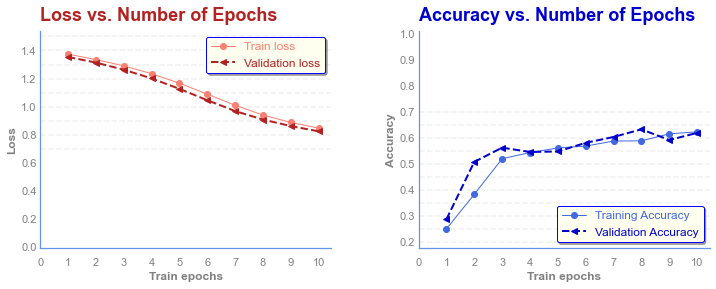

Test Accuracy: 0.6367


Experiment_2

Number of Epochs: 10
Activation function: relu
Optimizer: SGD
Learning Rate: 0.001


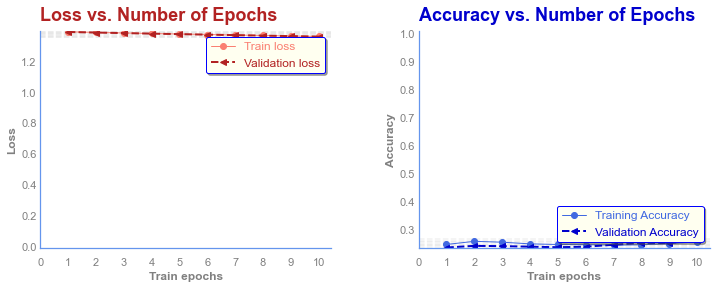

Test Accuracy: 0.2551


Experiment_3

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.01


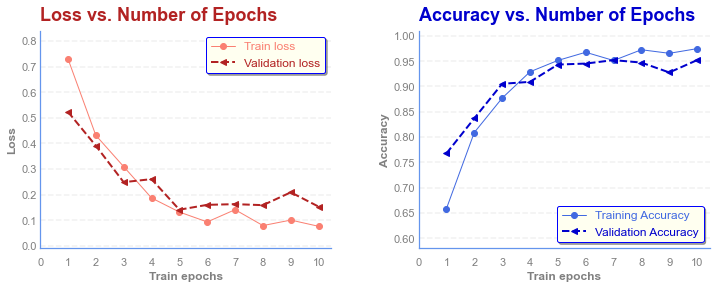

Test Accuracy: 0.9547


Experiment_4

Number of Epochs: 10
Activation function: tanh
Optimizer: Adam
Learning Rate: 0.001


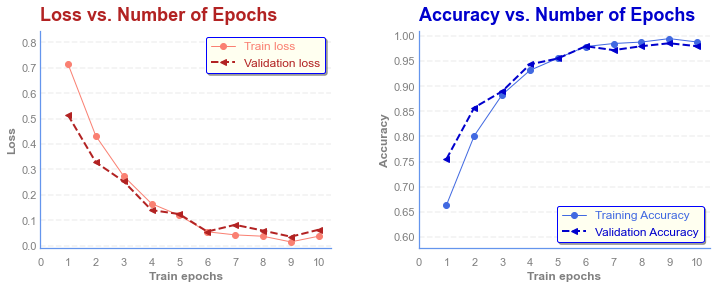

Test Accuracy: 0.9801


Experiment_5

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.01


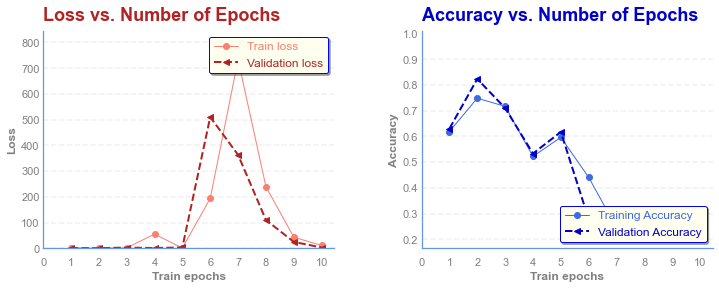

Test Accuracy: 0.2395


Experiment_6

Number of Epochs: 10
Activation function: relu
Optimizer: Adam
Learning Rate: 0.001


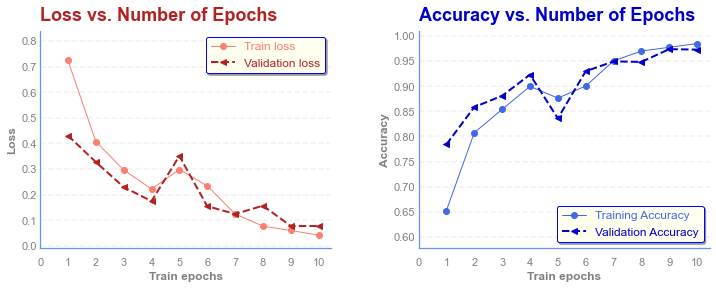

Test Accuracy: 0.9727




In [66]:
for i in range (1,len(experiments_blstmgru_df.index)+1):
    print('Experiment_' + str(i) + '\n')
    
    accu , param, metrics = build_n_run_blstmgru_model(X_train_pca_sq, Y_train, X_test_pca_sq, Y_test,
                                                  activ= experiments_blstmgru_df.loc['Experiment_' + str(i), 'activation'],
                                                  lear_rt = experiments_blstmgru_df.loc['Experiment_' + str(i), 'learning rate'],
                                                  optimiz = experiments_blstmgru_df.loc['Experiment_' + str(i), 'optimizer'])

    experiments_blstmgru_df.loc['Experiment_' + str(i), '# PARAMETERS'] = param
    experiments_blstmgru_df.loc['Experiment_' + str(i), 'TEST ACCURACY'] = accu
    experiments_blstmgru_df.loc['Experiment_' + str(i), 'TRAIN ACCURACY'] = metrics["train_accuracy"]
    experiments_blstmgru_df.loc['Experiment_' + str(i), 'VAL ACCURACY'] = metrics["val_accuracy"]
    #experiments_blstmgru_df.loc['Experiment_' + str(i), 'ACCURACY'] = metrics["accuracy"]
    experiments_blstmgru_df.loc['Experiment_' + str(i), 'PRECISON'] = metrics["precision"]
    experiments_blstmgru_df.loc['Experiment_' + str(i), 'RECALL'] = metrics["recall"]
    experiments_blstmgru_df.loc['Experiment_' + str(i), 'F1 SCORE'] = metrics["f1_score"]
    
    print('Test Accuracy: %1.4f' % accu + '\n\n')

In [67]:
experiments_blstmgru_df

activation  learning rate optimizer  # PARAMETERS  TEST ACCURACY  \
Experiment_1       relu          0.010       SGD      891679.0       0.636719   
Experiment_2       relu          0.001       SGD      891679.0       0.255078   
Experiment_3       tanh          0.010      Adam      891679.0       0.954687   
Experiment_4       tanh          0.001      Adam      891679.0       0.980078   
Experiment_5       relu          0.010      Adam      891679.0       0.239453   
Experiment_6       relu          0.001      Adam      891679.0       0.972656   

             TRAIN ACCURACY VAL ACCURACY PRECISON  RECALL F1 SCORE  
Experiment_1         0.5425       0.5449   0.6643  0.6425   0.6185  
Experiment_2         0.2493       0.2393   0.4260  0.2505   0.2084  
Experiment_3         0.9290       0.9092   0.9581  0.9557   0.9554  
Experiment_4         0.9315       0.9434   0.9802  0.9805   0.9803  
Experiment_5         0.5220       0.5332   0.2394  0.2448   0.1842  
Experiment_6         0.8996       0.9229   0.9739  0.9730   0.9728

<div style="padding:10px;background-color: cornflowerblue; color:white;font-size:28px;">Support Vector Machine (SVM) </div>

In [70]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}

svc=svm.SVC(
        probability=True 
        #,verbose=True enable for debug
        )

model=RandomizedSearchCV(
        svc, 
        param_grid, 
        cv=3, 
        n_jobs=-1 # use all cores
        #,verbose=4 enable for debug
    )

In [71]:
#Train model
model.fit(X_train_pca,Y_train)

RandomizedSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [0.0001, 0.001, 0.1, 1],
                                        'kernel': ['rbf', 'poly']})

In [72]:
#print results

Y_pred = model.predict(X_test_pca)

accuracy = accuracy_score(Y_test,Y_pred)
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1 = f1_score(Y_test, Y_pred, average='macro')

print('accuracy: ', accuracy)
print('precision: ', precision)
print('recall: ', recall)
print('F1 score: ', f1)


accuracy:  0.999609375
precision:  0.9996130030959752
recall:  0.9996223564954683
F1 score:  0.9996173871906969


In [73]:
# model.best_params_ contains the best parameters obtained from GridSearchCV
model.best_params_

{'kernel': 'poly', 'gamma': 1, 'C': 100}

In [74]:
end = timer()

In [75]:
print(end - start)

6390.5085034
